# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU

In [2]:
import pandas as pd
import numpy as np
pd.options.display.max_rows = 100
from math import floor
from collections import defaultdict

import colorsys
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyBboxPatch

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [3]:
CORP = Corpus.from_path('../sampletexts.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [4]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м    47  ¶  м  -  c  0.000120
1        мо  1366  м  о  c  v  0.003489
2        ож   804  о  ж  v  c  0.002054
3        же  1119  ж  е  c  v  0.002858
4        ет  1997  е  т  v  c  0.005101
...     ...   ... .. .. .. ..       ...
2487     яи     1  я  и  v  v  0.000003
2488     ыу     1  ы  у  v  v  0.000003
2489     ?”     1  ?  ”  -  -  0.000003
2490     .т     1  .  т  -  c  0.000003
2491     ч)     1  ч  )  c  -  0.000003

[2492 rows x 7 columns]

In [5]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   31214
е   23855
а   22927
и   20942
т   19916
н   15269
р   14270
с   11877
л   11081
в    8423
м    7581
к    7493
д    7226
ы    6754
у    6226
ь    5600
я    5150
з    3527
б    3458
г    3376
й    3297
х    3011
п    2717
ч    2702
ж    2445
ю    2081
ш    1623
ц    1411
ё    1221
щ    1109
ф     541
э     189
ъ     168

freq_out     freq_in      outer   frequency     outerness
ъ    4.291484    0.000000  -4.291484    4.291484 -10000.000000
ь    7.561186    0.255445  -7.305740    7.816631  -9346.405229
ы   40.028303    2.503365 -37.524938   42.531669  -8822.822823
п  134.006688   46.031272 -87.975416  180.037959  -4886.492622
а   66.364730   23.066725 -43.298005   89.431455  -4841.473865
и  112.293824   43.783352 -68.510472  156.077175  -4389.525368
у   27.000585   10.830887 -16.169698   37.831472  -4274.139095
о   86.621555   94.540364   7.918809  181.161919    437.112239
э    1.583762    2.043564   0.459802    3.627326   1267.605634
е   45.035034  126.317779  81.282745  171.352814   4743.589744
я    6.641582   55.150675  48.509093   61.792256   7850.351385
й    2.222375   84.194823  81.972448   86.417199   9485.663612
ё    0.153267    6.845938   6.692671    6.999206   9562.043796
ю    0.561980   38.802165  38.240185   39.364145   9714.471123

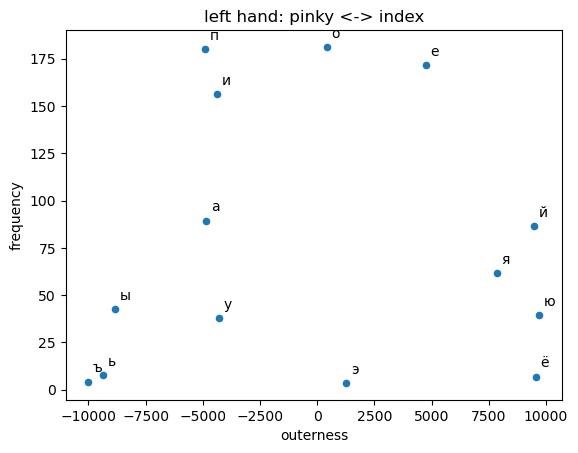

In [6]:
CORP.display_outerness("(t1 == 'v' | l1 == 'й' | l1 == 'п') & (t2 == 'v' | l2 == 'й' | l2 == 'п')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.332079    7.305740   -6.973661    7.637819 -9130.434783
ц     1.251683    8.480789   -7.229106    9.732472 -7427.821522
л    16.910489   85.957397  -69.046907  102.867886 -6712.192699
р    62.430870  182.285879 -119.855009  244.716749 -4897.703549
н    76.659182  158.146283  -81.487101  234.805466 -3470.409051
т   120.391445  216.490026  -96.098582  336.881471 -2852.593267
ф     3.933860    5.236632   -1.302772    9.170492 -1420.612813
к    55.099585   70.400768  -15.301183  125.500354 -1219.214329
м    24.062962   28.533258   -4.470296   52.596220  -849.927149
ш     9.451482    8.940591    0.510891   18.392073   277.777778
в    65.675027   56.785525    8.889502  122.460553   725.907384
х     8.812868    6.743760    2.069108   15.556628  1330.049261
д    54.358794   40.513650   13.845144   94.872443  1459.343026
г    26.694050   10.958610   15.735440   37.652661  4179.104478
ж    25.851080   10.243363   15.607718   36.094443  4324.133050
с   254.117142   94.029473  160.087669  348.146615  4598.283073
п    89.737990   25.442368   64.295622  115.180357  5582.168995
ч    39.032066    8.761779   30.270287   47.793845  6333.511491
б    34.996028    7.075839   27.920189   42.071867  6636.308440
з    47.308499    4.036038   43.272461   51.344537  8427.860697
й    19.286132    0.025545   19.260588   19.311677  9973.544974

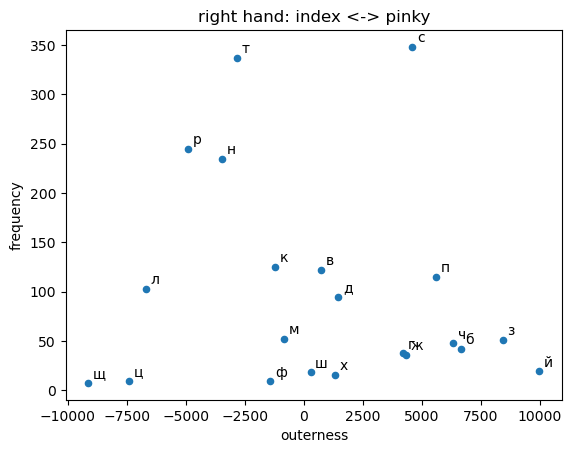

In [7]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [8]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [9]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [10]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
8642226 622246
6421134 431124
 400002 200002
 211114 4111
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [11]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    'optozorax': # 2021 https://optozorax.github.io/p/my-keyboard-layout/#russkii-iazyk
    # author never mentions parens in his keyboard definition. I just tossed them wherever there was place.
    ('''
    
+;.:=@∅ ∅*!?#/∅
-йцуеф∅ ∅щгтнз∅
"кмвап   ролджэ
'ячсиы∅ ,шьбюхё
∅∅∅∅∅∅∅ ∅∅∅\∅∅∅
    ∅∅¶ .⌴∅

(75319^ №02468)
_∅∅∅∅∅∅ $∅∅∅∅∅∅
&∅∅∅∅∅   ∅∅∅∅∅∅
|∅∅∅∅∅∅ ∅∅ъ∅∅∅∅
∅∅∅∅∅     ∅%∅∅∅
    ∅∅∅ ∅∅∅
''',
ERGODOX),
    
    'ergodox':  # standard Russian on Ergodox (has troubles with right end of the upper row)
(''' 
ё123456 7890\ъ∅
-йцуке∅ ∅нгшщзх
=фывап   ролджэ
∅ячсми∅ ∅тьбю.∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅,∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест33эрго': 
(r''' 
ъ123456 7890-=/
шщфыхэ∅ ∅жмвкзч
=аоией   ,ртнсд
∅ьуюяё∅ ∅цлбпг∅
∅∅∅∅∅     ∅∅∅∅∅
    ⌴→∅ ∅¶∅

∅!"№;%: ?*()/∅∅
_∅∅∅∅∅∅ ∅∅∅∅∅∅∅
+∅∅∅∅∅   .∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅     ∅∅∅∅∅
    ∅∅∅ ∅∅∅

''',
ERGODOX),

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [12]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 2.9009
key """ repeated: 2
key "?" repeated: 2
layout usphonetic: 2.9574
layout rusdvorak: 1.5657
key ":" repeated: 2
layout диктор: 1.3795
layout зубачёв: 1.3378
key "." repeated: 2
layout скоропис: 1.3505
key ":" repeated: 2
key """ repeated: 3
key ";" repeated: 2
layout ант: 1.5614
layout ugnvs: 1.7874
layout леонов: 1.244
layout леонов2: 1.0728
layout леонов3: 1.2913
key "." repeated: 2
layout optozorax: 2.0986
layout ergodox: 2.9602
layout тест1: 2.6154
layout тест2: 2.1966
layout тест3: 1.9499
layout тест4: 1.71
layout тест5: 1.5841
layout тест6: 1.5415
layout тест7: 1.5552
layout тест8: 1.5311
layout тест9: 1.5362
layout тест10: 1.5221
layout тест11: 1.5499
layout тест12: 1.4116
layout тест13: 1.4171
layout тест14: 1.3564
layout тест15: 1.2866
layout тест16: 1.2794
layout тест17: 1.2361
layout тест18: 1.2442
layout тест19: 1.2545
layout тест20: 1.2532
layout тест21: 1.2067
layout тест22: 1.2067
layout тест23: 1.1976
layout тест24: 1.1901
layout тест25: 1.1979
layo

# Final Standings <a name="standings">

In [13]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест34', 'Best and currently in use on my laptop'),
    ('тест36', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

print('\nErgodox league:\n')
chosen_kbd = [
    ('optozorax', 'ErgoDox Moonlander, alien'),
    ('ergodox', 'Stardand Russian on Ergodox'),
    ('тест33эрго', 'My best layout minimally adapted to Ergodox'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# how well I am against Leonov's layout (the best of eariler authors' layouts)
print('\nimprovement over Leonov\'s layout', round(1 - results['тест31'].score / results['леонов'].score, 3))

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   0.936 | Alien #2, many counterparts on AltGr   |
| тест36     |   1.088 | Best and currently in use on my laptop |
| тест34     |   1.108 | Best and currently in use on my laptop |
| ино1       |   1.121 | Alien #1, rare letters on AltGr        |
| леонов     |   1.244 | Leonov                                 |
| зубачёв    |   1.338 | Zubachov                               |
| скоропис   |   1.35  | Skoropis                               |
| диктор     |   1.379 | Dictor                                 |
| тест10     |   1.522 | First optimized after hand testing     |
| тест9      |   1.536 | First hand-tested                      |
| ант        |   1.561 | ANT                                    |
| rusdvorak  |   1.566 | Dvorak translit                        |
| ugnvs      |   1.787 | UGNVS                   

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

In [14]:
lyt = Layout('тест37', (r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсг¶
 ьуюяё цлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

тест37 : 1.101 


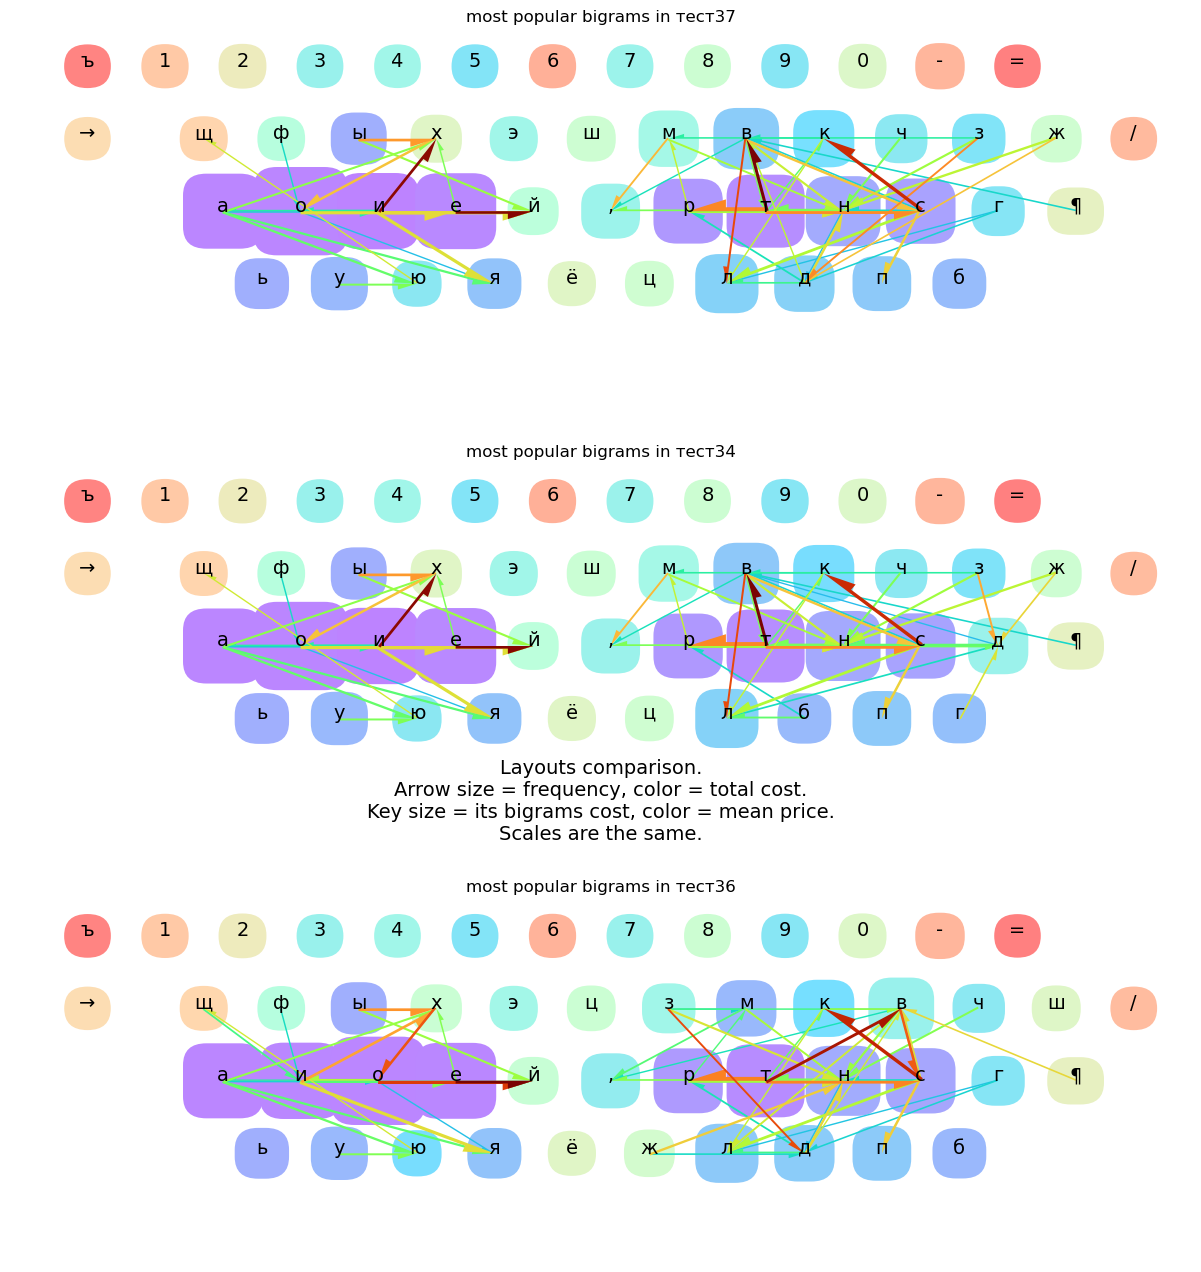

In [15]:
r.combomap(results['тест34'], results['тест36'])

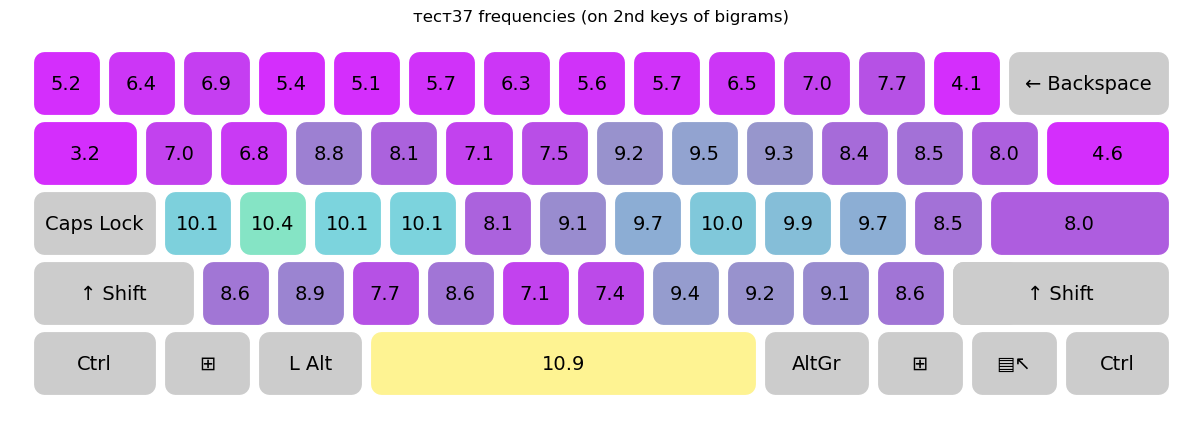

In [16]:
results['тест37'].display('num')

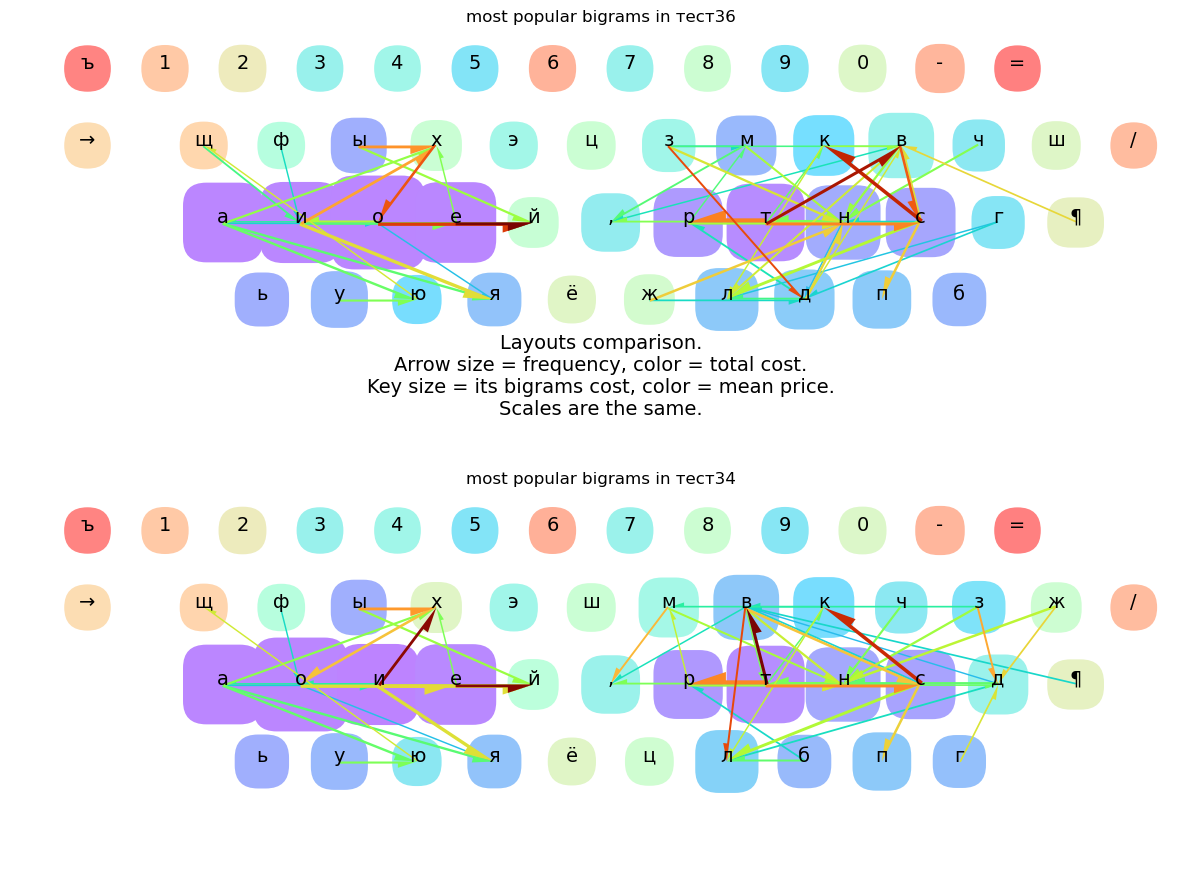

In [17]:
results['тест36'].combomap(results['тест34'])

In [18]:
results['тест34'].compare(results['тест36']).sort_values('delta', ascending=False).head(30)

bigram   num                     category_old  price_old  cost_old  \
18      ⌴в  4955                        space bar          1      4955   
35      ов  3193                     altern hands          1      3193   
181     ой  1149      in, over 1 finger, same row          2      2298   
273     ¶в   294       in, over 1 finger, adj row          2       588   
348     св   281       in, over 1 finger, adj row          2       562   
412     дв   207       in, over 1 finger, adj row          2       414   
153     ог  1500                     altern hands          1      1500   
94      ⌴з  1384                        space bar          2      2768   
79      ⌴г  1384                        space bar          1      1384   
194     хо   684             out, over one finger          4      2736   
465     вс   674             out, over one finger          4      2696   
184     ое   665      in, over 1 finger, same row          0         0   
411     дн   588  in, adj finger, same or adj row          2      1176   
447     зд   390              same finger adj row          8      3120   
116     аз  1101                     altern hands          2      2202   
42      ав  1074                     altern hands          1      1074   
64      из   970                     altern hands          2      1940   
108     ив   860                     altern hands          1       860   
257     ои   417  in, adj finger, same or adj row          2       834   
464     зв   255      in, over 1 finger, same row          1       255   
453     дк   107          pinky -> ring, next row          4       428   
460     кв   248  in, adj finger, same or adj row          3       744   
316     ох   177  in, adj finger, same or adj row          4       708   
512     др   351      in, over 1 finger, same row          0         0   
380     щи   338       in, over 1 finger, adj row          1       338   
387     жн   625          pinky -> ring, next row          3      1875   
332     ег   617                     altern hands          1       617   
196     зн   529          pinky -> ring, next row          3      1587   
920     зр    99       in, over 1 finger, adj row          1        99   
386     лж   123                   index -> pinky          6       738   

                        category_new  price_new  cost_new  delta  
18                         space bar          2      9910   4955  
35                      altern hands          2      6386   3193  
181  in, adj finger, same or adj row          4      4596   2298  
273              same finger adj row          8      2352   1764  
348              same finger adj row          8      2248   1686  
412        over 1 finger, over 1 row         10      2070   1656  
153                     altern hands          2      3000   1500  
94                         space bar          3      4152   1384  
79                         space bar          2      2768   1384  
194              same finger adj row          6      4104   1368  
465              same finger adj row          6      4044   1348  
184  in, adj finger, same or adj row          2      1330   1330  
411             out, over one finger          4      2352   1176  
447              adj finger over row         11      4290   1170  
116                     altern hands          3      3303   1101  
42                      altern hands          2      2148   1074  
64                      altern hands          3      2910    970  
108                     altern hands          2      1720    860  
257             out, over one finger          4      1668    834  
464                   index -> pinky          4      1020    765  
453              adj finger over row         11      1177    749  
460             out, over one finger          6      1488    744  
316              same finger adj row          8      1416    708  
512  in, adj finger, same or adj row          2       702    702  
380          pinky -> ring, next r

In [19]:
results['тест36'].bigrams[results['тест36'].bigrams.bigram == 'ом']

bigram   num l1 l2 t1 t2      freq  price_l2  price_di      category  \
191     ом  1719  о  м  v  c  0.004391         1         0  altern hands   

     price  cost  finger  column  row   h1   h2  
191      1  1719     7.0     9.0  1.0  0.0  1.0

In [20]:
results['тест34'].layout.keymap.loc['м']

layer        0
row          1
column       8
key_count    1
finger       6
ftype        1
hand         1
penalty      3
Name: м, dtype: int64

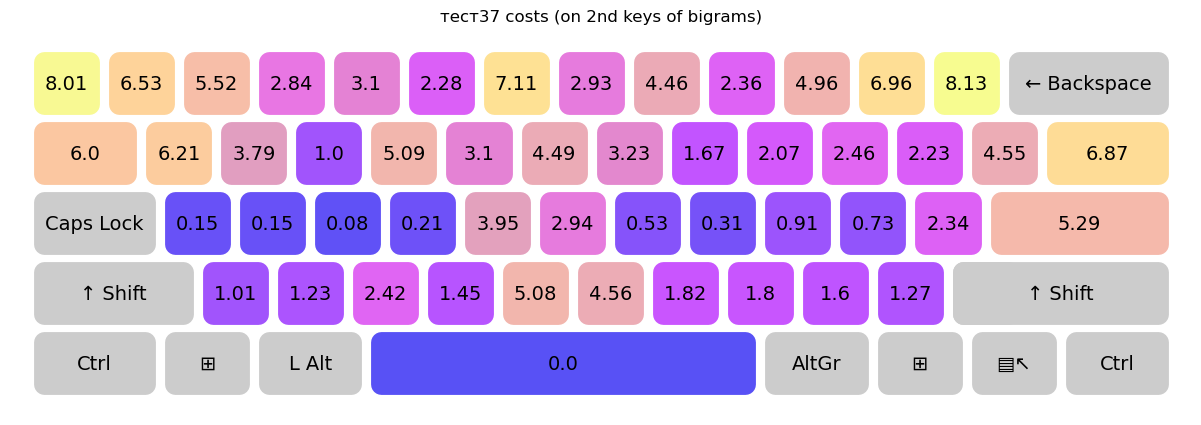

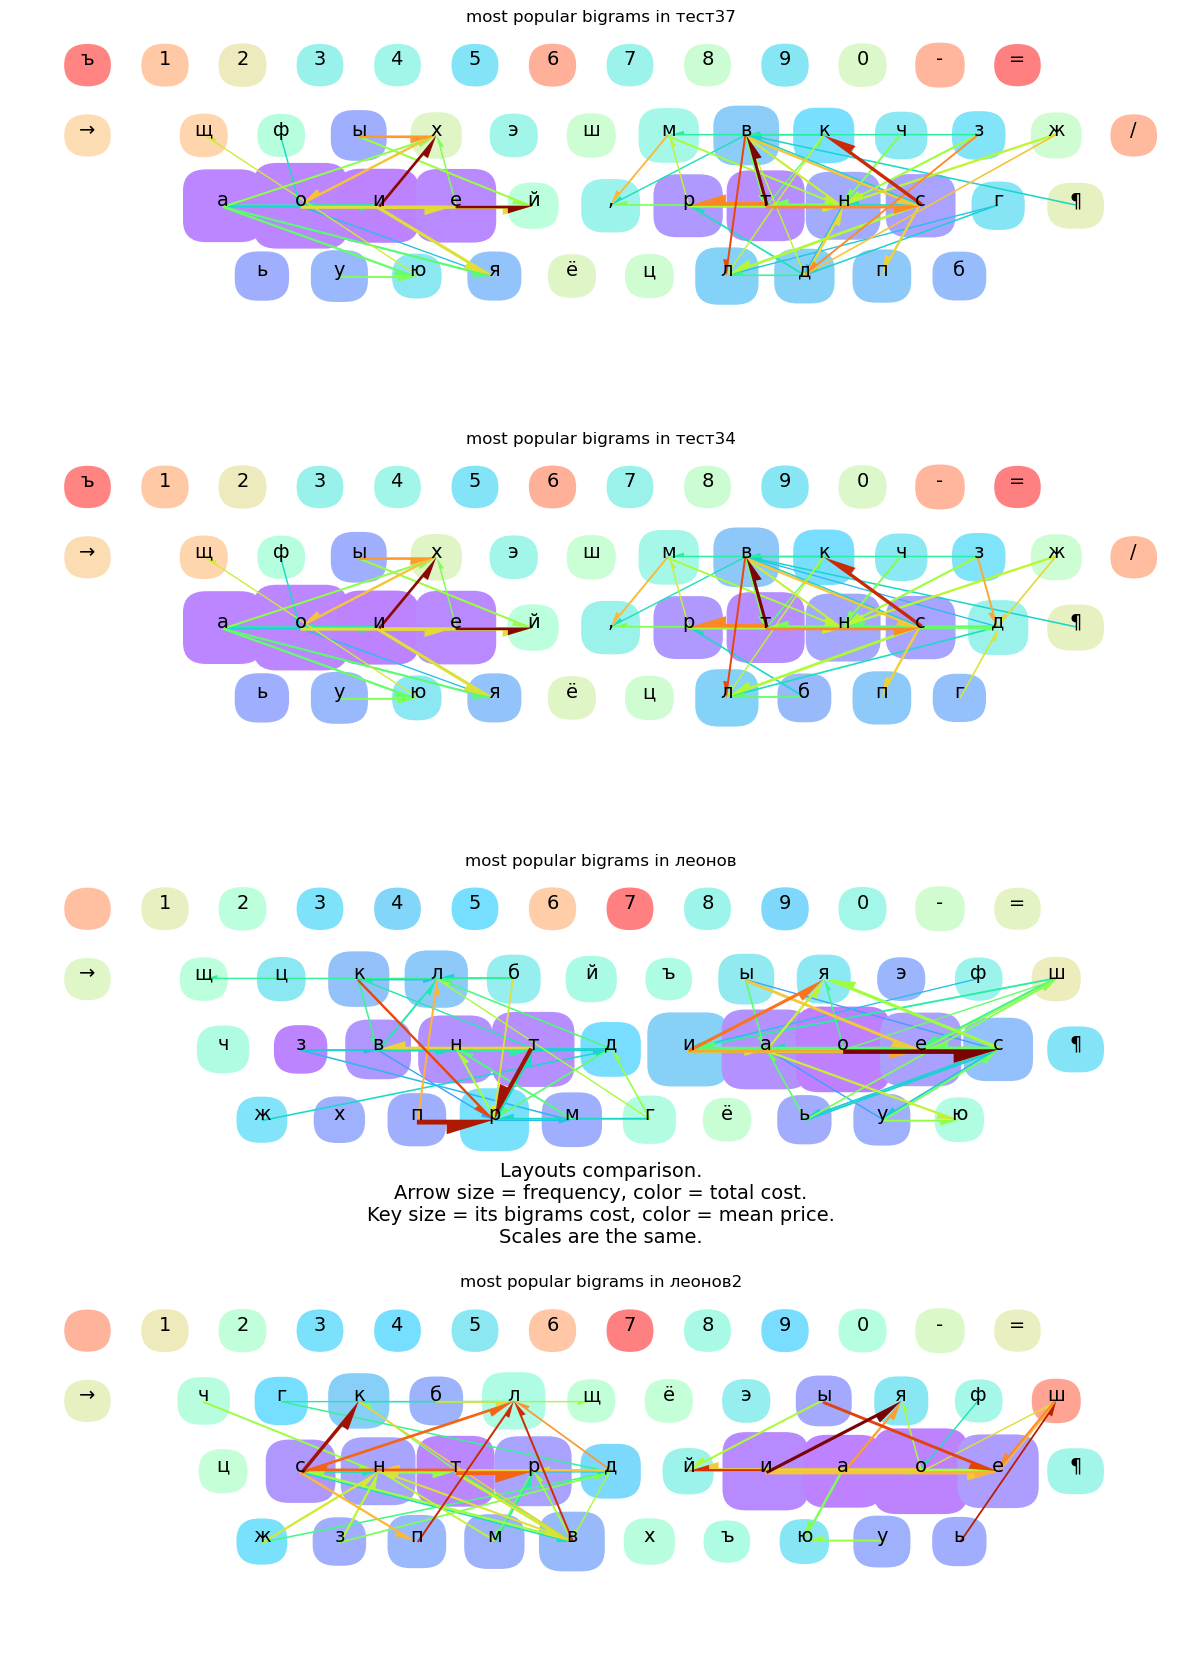

In [21]:
r.display('cost')
r.combomap(results['тест34'], results['леонов'], results['леонов2'])

       cost     num
h2                 
0.0  118292  205344
1.0  315292  182858


<AxesSubplot: xlabel='finger'>

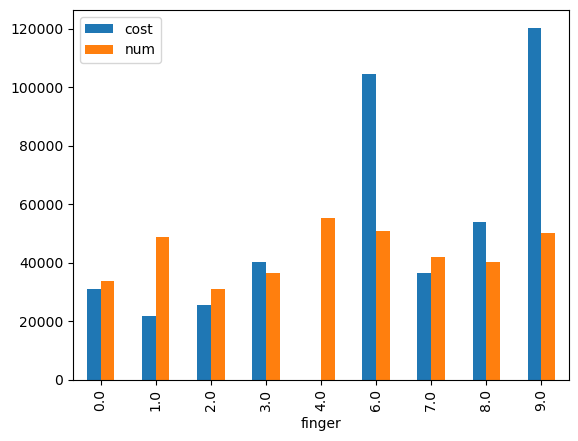

In [22]:
print(results['тест34'].bigrams.groupby('h2').agg({'cost': 'sum', 'num': 'sum'}))
results['тест34'].bigrams.groupby('finger').agg({'cost': 'sum', 'num': 'sum'}).plot.bar()

       cost     num
h2                 
0.0  118292  205344
1.0  312626  182858


<AxesSubplot: xlabel='finger'>

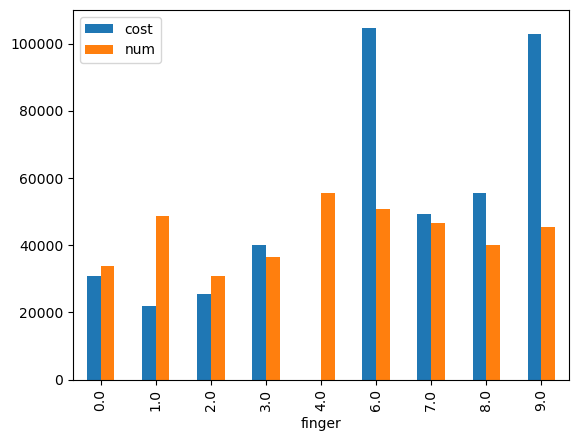

In [23]:
print(r.bigrams.groupby('h2').agg({'cost': 'sum', 'num': 'sum'}))
r.bigrams.groupby('finger').agg({'cost': 'sum', 'num': 'sum'}).plot.bar()

In [24]:
r.bigrams[r.bigrams.bigram=='по']

bigram   num l1 l2 t1 t2      freq  price_l2  price_di      category  \
55     по  3115  п  о  c  v  0.007957         0         0  altern hands   

    price  cost  finger  column  row   h1   h2  
55      0     0     1.0     2.0  2.0  1.0  0.0

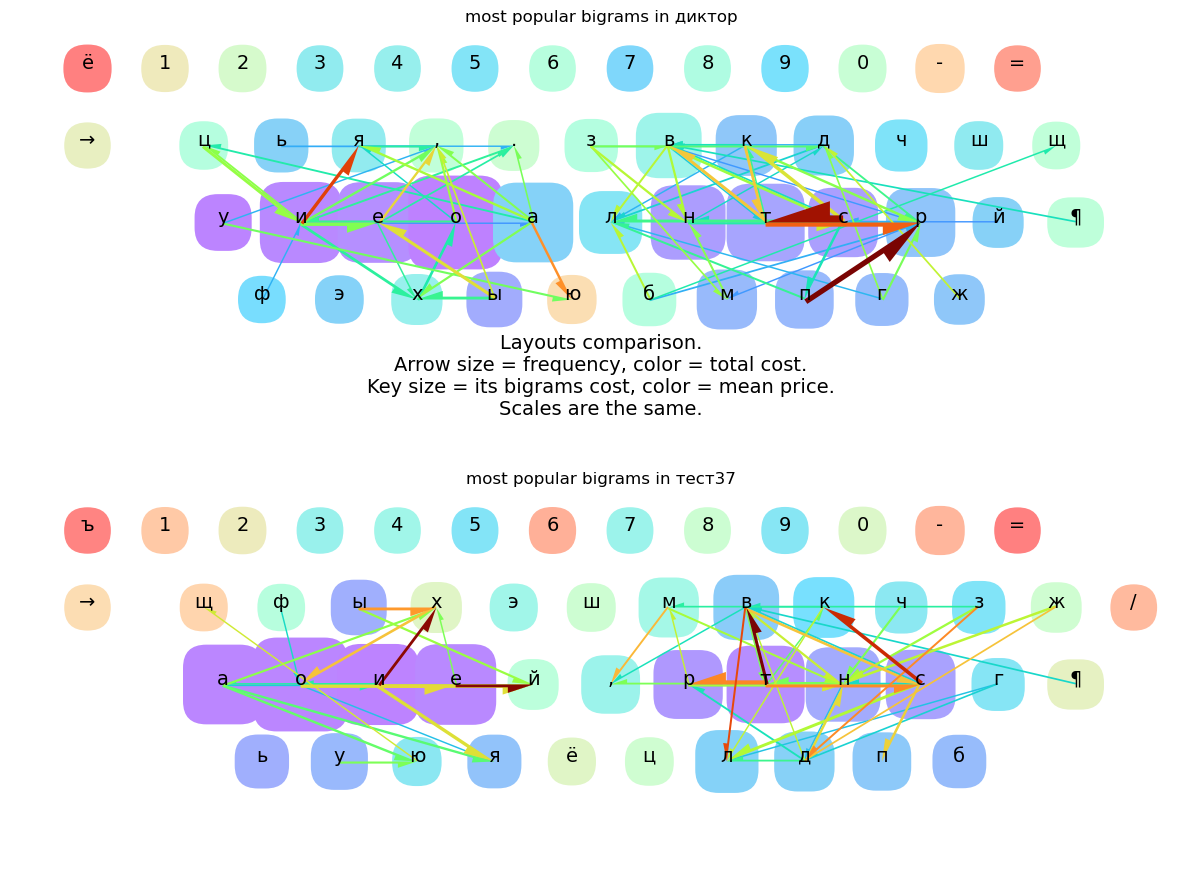

In [25]:
results['диктор'].combomap(r)

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

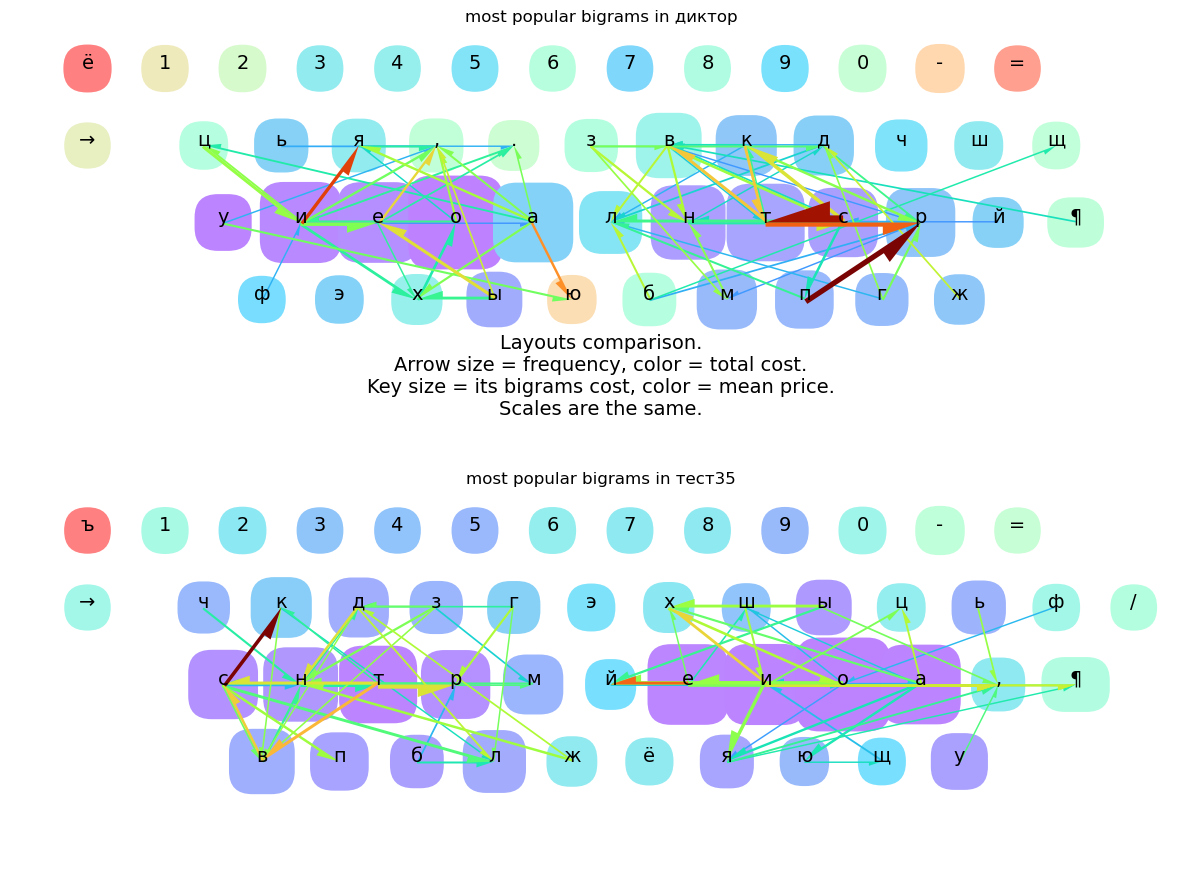

In [26]:
results['диктор'].combomap(results['тест35'])

## Losses

In [27]:
compare(results, 'тест32', 'тест33').head(30)

bigram   num                     category_old  price_old  cost_old  \
25      ⌴м  2178                        space bar          1      2178   
191     ом  1719                     altern hands          1      1719   
41      пр  2820                     altern hands          0         0   
102     ем  1336                     altern hands          1      1336   
106     им  1168                     altern hands          1      1168   
111     их   776             out, over one finger          5      3880   
299     ам  1101                     altern hands          1      1101   
302     сп   628                     altern hands          1       628   
192     м,   365  in, adj finger, same or adj row          4      1460   
379     ющ   208                     altern hands          4       832   
435     ию   199                    in, lower row          2       398   
331     ущ   122                     altern hands          4       488   
378     ую   447      in, over 1 finger, same row          1       447   
239     ым   437                     altern hands          1       437   
146     рм   216             out, over one finger          5      1080   
916     ща   141                     altern hands          0         0   
71      ых   829  in, adj finger, same or adj row          3      2487   
346     бл   398      in, over 1 finger, same row          1       398   
611     щё   151                     altern hands          3       453   
223     мп    94                     altern hands          1        94   
473     ях   106             out, over one finger          5       530   
949     ёх    93             out, over one finger          5       465   
424     м.   158  in, adj finger, same or adj row          4       632   
351     вп    57                     altern hands          1        57   
973     оф   114                    in, lower row          2       228   
612     яе   113                    in, lower row          1       113   
362     ум   280                     altern hands          1       280   
824     пн    88                     altern hands          0         0   
353     -п    52                     altern hands          1        52   
54      ¶п   166                     altern hands          1       166   

                        category_new  price_new  cost_new  delta  
25                         space bar          3      6534   4356  
191                     altern hands          3      5157   3438  
41        in, over 1 finger, adj row          1      2820   2820  
102                     altern hands          3      4008   2672  
106                     altern hands          3      3504   2336  
111              same finger adj row          8      6208   2328  
299                     altern hands          3      3303   2202  
302          pinky -> ring, next row          4      2512   1884  
192              same finger adj row          8      2920   1460  
379        over 1 finger, over 1 row         10      2080   1248  
435              same finger adj row          7      1393    995  
331              adj finger over row         12      1464    976  
378  in, adj finger, same or adj row          3      1341    894  
239                     altern hands          3      1311    874  
146              same finger adj row          9      1944    864  
916              same finger adj row          6       846    846  
71   in, adj finger, same or adj row          4      3316    829  
346  in, adj finger, same or adj row          3      1194    796  
611        pinky -> index over 1 row          8      1208    755  
223        over 1 finger, over 1 row          9       846    752  
473              adj finger over row         12      1272    742  
949              adj finger over row         12      1116    651  
424              same finger adj row          8      1264    632  
351              adj finger over row         11       627    570  
973          ring -> pinky, next r

## Gains

In [28]:
compare(results, 'тест32', 'тест33').tail(30)

bigram   num                     category_old  price_old  cost_old  \
285     шл   107             same finger over row          9       963   
96      оя   216  in, adj finger, same or adj row          4       864   
274     ах   479          pinky -> ring, next row          4      1916   
436     пу   248  in, adj finger, same or adj row          3       744   
316     ох   177              same finger adj row          7      1239   
410     ип   139             out, over one finger          5       695   
277     ая   572       in, over 1 finger, adj row          3      1716   
339     ля   620                     altern hands          2      1240   
157     ты   664                     altern hands          2      1328   
70      ры   665                     altern hands          2      1330   
224     пе   776       in, over 1 finger, adj row          1       776   
205     бы   820                     altern hands          2      1640   
445     пы    95             same finger over row         10       950   
923     яю   100              adj finger over row         11      1100   
182     ⌴э   983                        space bar          4      3932   
112     вы  1020                     altern hands          2      2040   
265     фи   209              same finger adj row          6      1254   
131     ся  1192                     altern hands          2      2384   
194     хо   684              same finger adj row          6      4104   
159     уп   357             out, over one finger          5      1785   
498     зм   290        over 1 finger, over 1 row          9      2610   
291     ап   336              same finger adj row          7      2352   
46      ль  2056                     altern hands          2      4112   
236     ны  2235                     altern hands          2      4470   
38      ть  2493                     altern hands          2      4986   
188     бщ   231              adj finger over row         14      3234   
295     оп   568          ring -> pinky, next row          6      3408   
303     па   477              same finger adj row          6      2862   
262     ия  1139              same finger adj row          8      9112   
55      по  3115          pinky -> ring, next row          3      9345   

                        category_new  price_new  cost_new  delta  
285        pinky -> index over 1 row          5       535   -428  
96        in, over 1 finger, adj row          2       432   -432  
274       in, over 1 finger, adj row          3      1437   -479  
436                     altern hands          1       248   -496  
316  in, adj finger, same or adj row          4       708   -531  
410                     altern hands          1       139   -556  
277       in, over 1 finger, adj row          2      1144   -572  
339                     altern hands          1       620   -620  
157                     altern hands          1       664   -664  
70                      altern hands          1       665   -665  
224                     altern hands          0         0   -776  
205                     altern hands          1       820   -820  
445                     altern hands          1        95   -855  
923           index->middle same row          2       200   -900  
182                        space bar          3      2949   -983  
112                     altern hands          1      1020  -1020  
265       in, over 1 finger, adj row          1       209  -1045  
131                     altern hands          1      1192  -1192  
194             out, over one finger          4      2736  -1368  
159                     altern hands          1       357  -1428  
498      in, over 1 finger, same row          3       870  -1740  
291                     altern hands          1       336  -2016  
46                      altern hands          1      2056  -2056  
236                     altern hands          1      2235  -2235  
38                      altern han

You can save the comparison table to CSV:

In [29]:
compare(results, 'леонов', 'тест33').to_csv('leonov-test33.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [30]:
results['тест33'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram   num l1 l2 t1 t2      freq  price_l2  price_di  \
25      ⌴м  2178  ⌴  м  -  c  0.005564         3         0   
177     .¶  1085  .  ¶  -  -  0.002772         4         2   
49      тв   926  т  в  c  c  0.002365         1         6   
296     ей   790  е  й  v  c  0.002018         2         6   
111     их   776  и  х  v  c  0.001982         2         6   
40      ⌴п  5662  ⌴  п  -  c  0.014463         1         0   
124     ⌴-   886  ⌴  -  -  -  0.002263         6         0   
191     ом  1719  о  м  v  c  0.004391         3         0   
114     ск  1284  с  к  c  c  0.003280         1         3   
227     ⌴д  2489  ⌴  д  -  c  0.006358         2         0   
18      ⌴в  4955  ⌴  в  -  c  0.012657         1         0   
195     од  2317  о  д  v  c  0.005919         2         0   
338     вл   403  в  л  c  c  0.001029         1        10   
53      ¶¶  1033  ¶  ¶  -  -  0.002639         4         0   
102     ем  1336  е  м  v  c  0.003413         3         0   
78      тр  1768  т  р  c  c  0.004516         0         2   
130     тс   879  т  с  c  c  0.002245         0         4   
106     им  1168  и  м  v  c  0.002984         3         0   
71      ых   829  ы  х  v  c  0.002118         2         2   
299     ам  1101  а  м  v  c  0.002812         3         0   
2       ож   804  о  ж  v  c  0.002054         4         0   
35      ов  3193  о  в  v  c  0.008156         1         0   
447     зд   390  з  д  c  c  0.000996         2         6   
182     ⌴э   983  ⌴  э  -  v  0.002511         3         0   
133     ⌴ч  1466  ⌴  ч  -  c  0.003745         2         0   
192     м,   365  м  ,  c  -  0.000932         2         6   
41      пр  2820  п  р  c  c  0.007204         0         1   
94      ⌴з  1384  ⌴  з  -  c  0.003535         2         0   
30      ⌴к  2760  ⌴  к  -  c  0.007050         1         0   
194     хо   684  х  о  c  v  0.001747         0         4   

                            category  price  cost  finger  column  row  
25                         space bar      3  6534     6.0     8.0  1.0  
177                   index -> pinky      6  6510     9.0    13.0  2.0  
49               same finger adj row      7  6482     7.0     9.0  1.0  
296              same finger adj row      8  6320     3.0     5.0  2.0  
111              same finger adj row      8  6208     2.0     4.0  1.0  
40                         space bar      1  5662     8.0    10.0  3.0  
124                        space bar      6  5316     9.0    12.0  0.0  
191                     altern hands      3  5157     6.0     8.0  1.0  
114          pinky -> ring, next row      4  5136     8.0    10.0  1.0  
227                        space bar      2  4978     9.0    12.0  2.0  
18                         space bar      1  4955     7.0     9.0  1.0  
195                     altern hands      2  4634     9.0    12.0  2.0  
338              adj finger over row     11  4433     6.0     8.0  3.0  
53                          same key      4  4132     9.0    13.0  2.0  
102                     altern hands      3  4008     6.0     8.0  1.0  
78   in, adj finger, same or adj row      2  3536     6.0     8.0  2.0  
130             out, over one finger      4  3516     9.0    11.0  2.0  
106                     altern hands      3  3504     6.0     8.0  1.0  
71   in, adj finger, same or adj row      4  3316     2.0     4.0  1.0  
299                     altern hands      3  3303     6.0     8.0  1.0  
2                       altern hands      4  3216     6.0     7.0  1.0  
35                      altern hands      1  3193     7.0     9.0  1.0  
447              same finger adj row      8  3120     9.0    12.0  2.0  
182                        space bar      3  2949     3.0     5.0  1.0  
133                        space bar      2  2932     9.0    12.0  1.0  
192              same finger adj row      8  2920     6.0     7.0  2.0  
41        in, over 1 finger, adj row      1  2820     6.0     8.0  2.0  
94                         space bar 

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [31]:
key = 'тест33' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [32]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        8
1      0    0       1          1       0      4     0        6
2      0    0       2          1       0      4     0        4
3      0    0       3          1       0      4     0        2
4      0    0       4          1       1      3     0        2
5      0    0       5          1       2      2     0        2
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        2
0      0    0      11          1       9      4     1        4
-      0    0      12          1       9      4     1        6
=      0    0      13          1       9      4     1        8
→      0    1       0          1       0      4     0        6
щ      0    1       1          1       0      4     0        2
ф      0    1       2          1       0      4     0        2
ы      0    1       3          1       1      3     0        1
х      0    1       4          1       2      2     0        2
э      0    1       5          1       3      1     0        3
ш      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        1
ч      0    1      11          1       9      4     1        2
з      0    1      12          1       9      4     1        2
ж      0    1      13          1       9      4     1        4
/      0    1      14          1       9      4     1        6
а      0    2       1          1       0      4     0        0
о      0    2       2          1       1      3     0        0
и      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
й      0    2       5          1       3      1     0        2
,      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        0
с      0    2      11          1       9      4     1        0
г      0    2      12          1       9      4     1        2
¶      0    2      13          1       9      4     1        4
ь      0    3       1          1       0      4     0        1
у      0    3       2          1       1      3     0        1
ю      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ё      0    3       5          1       3      1     0        4
ц      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
д      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        1
б      0    3      11          1       9      4     1        1
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        8
!      1    0       1          1       0      4     0        6
"      1    0       2          1       0      4     0        4
№      1    0       3          1       0      4     0        2
;      1    0       4          1       1      3     0        2
%      1    0       5          1       2      2     0        2
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        2
)      1    0      11          1       9      4     1        4
_      1    0      12          1       9      4     1        6
+      1    0      13          1  

# Ergodox League <a name="ergodox">

Let's compare the standard layout on Ergodox with Optozorax' one.
    
The first test here showed that I got finger numbers wrong in `ERGODOX`, that's why this is also helpful.

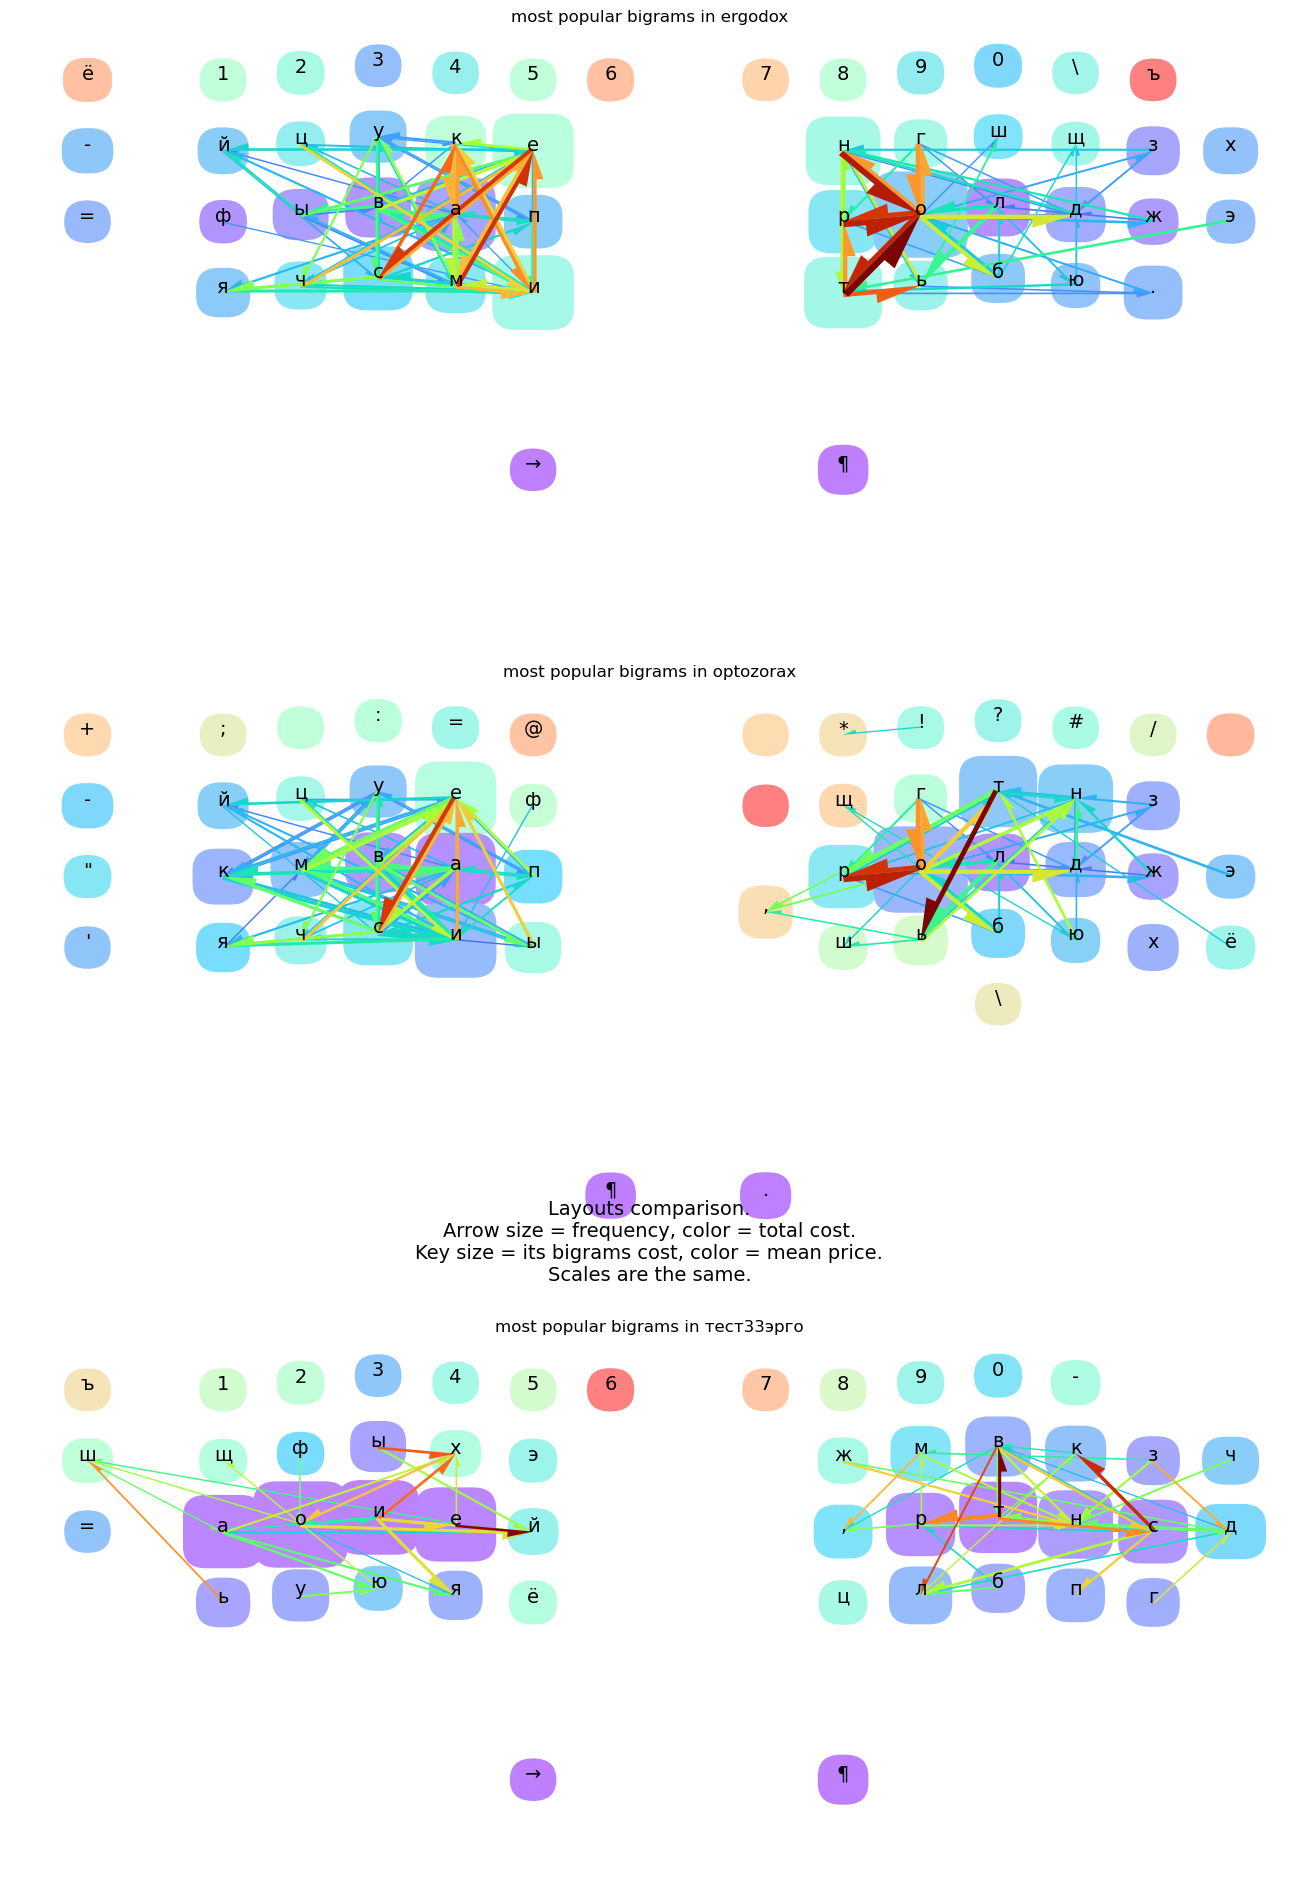

In [33]:
results['ergodox'].combomap(results['optozorax'], results['тест33эрго'])

As we can see in the map above, йцукен on Ergodox is harder in most keys. Let's see what letters were improved actually:

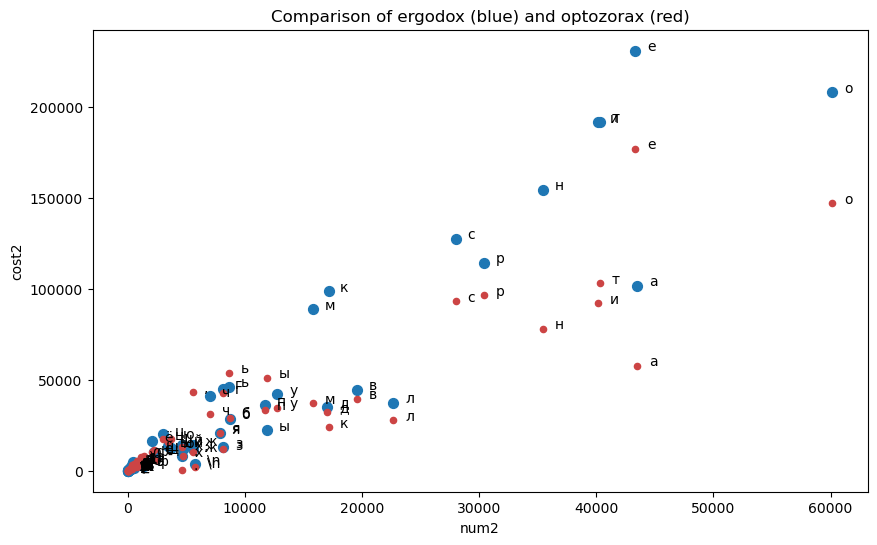

In [34]:
results['ergodox'].combochart(results['optozorax'])

But you may notice that Optozorax' layout is actually a modest modification of the standard ЙЦУКЕН. How far can we improve it? I've simply translated my test28, moving the rightmost letter Ж to the left side, and slash to up-right corner. The result scores 2.5 times better.

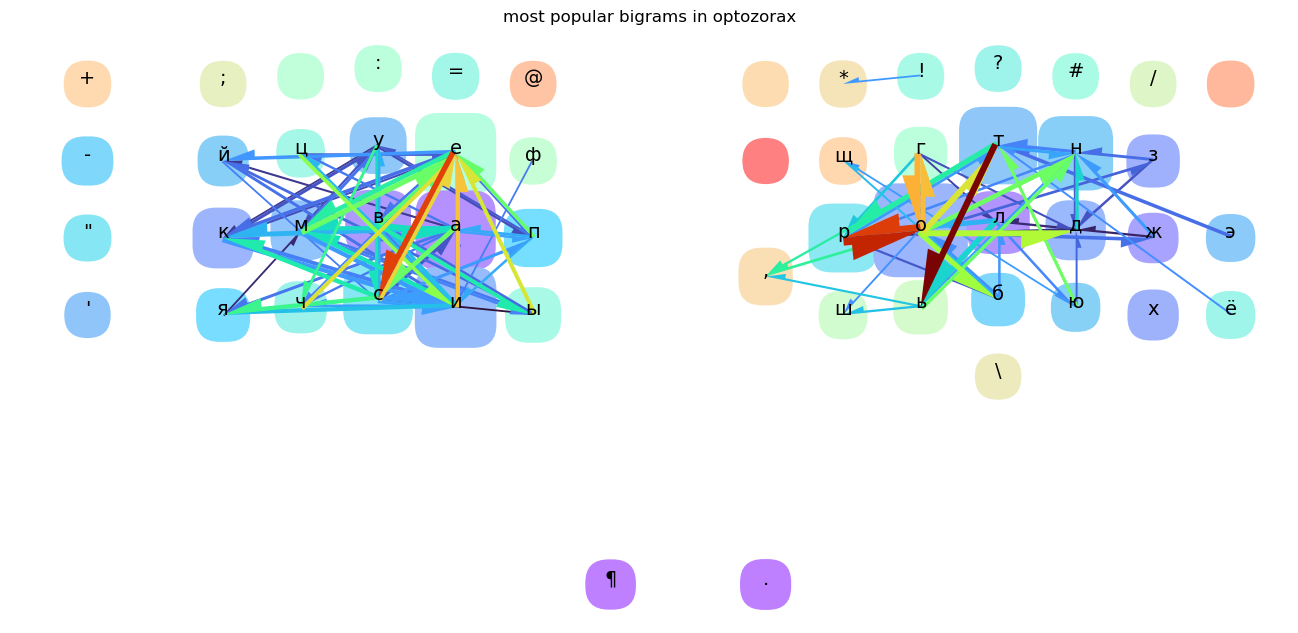

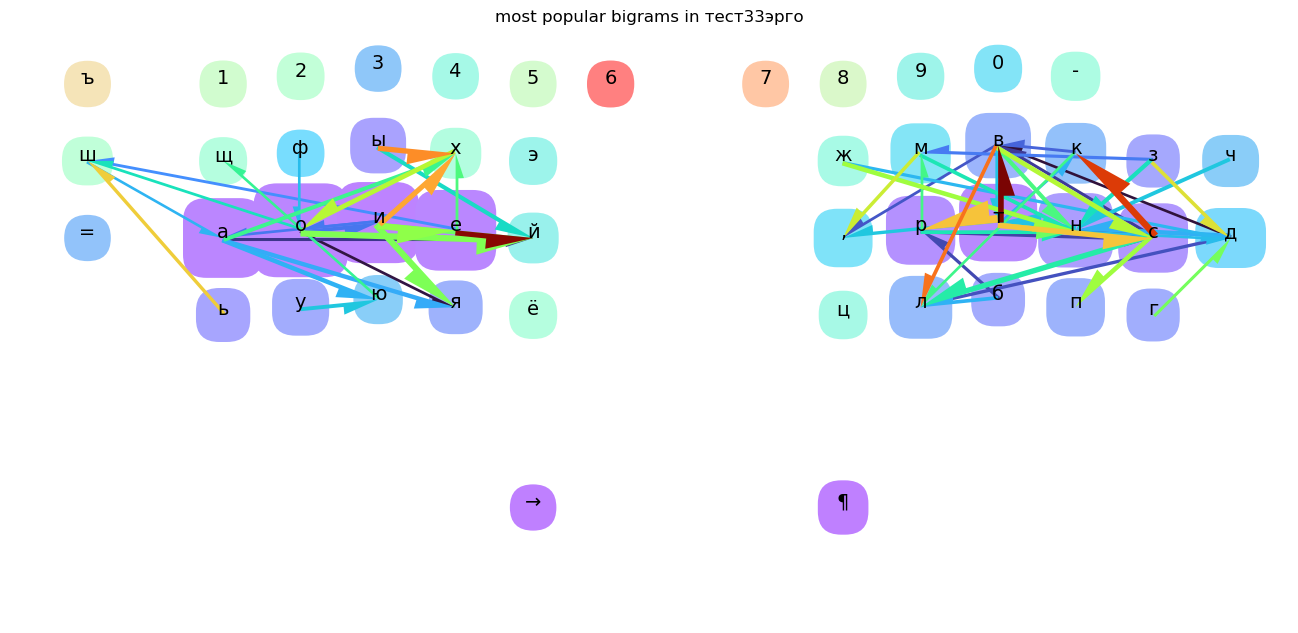

In [35]:
results['optozorax'].display('arrows')
results['тест33эрго'].display('arrows')


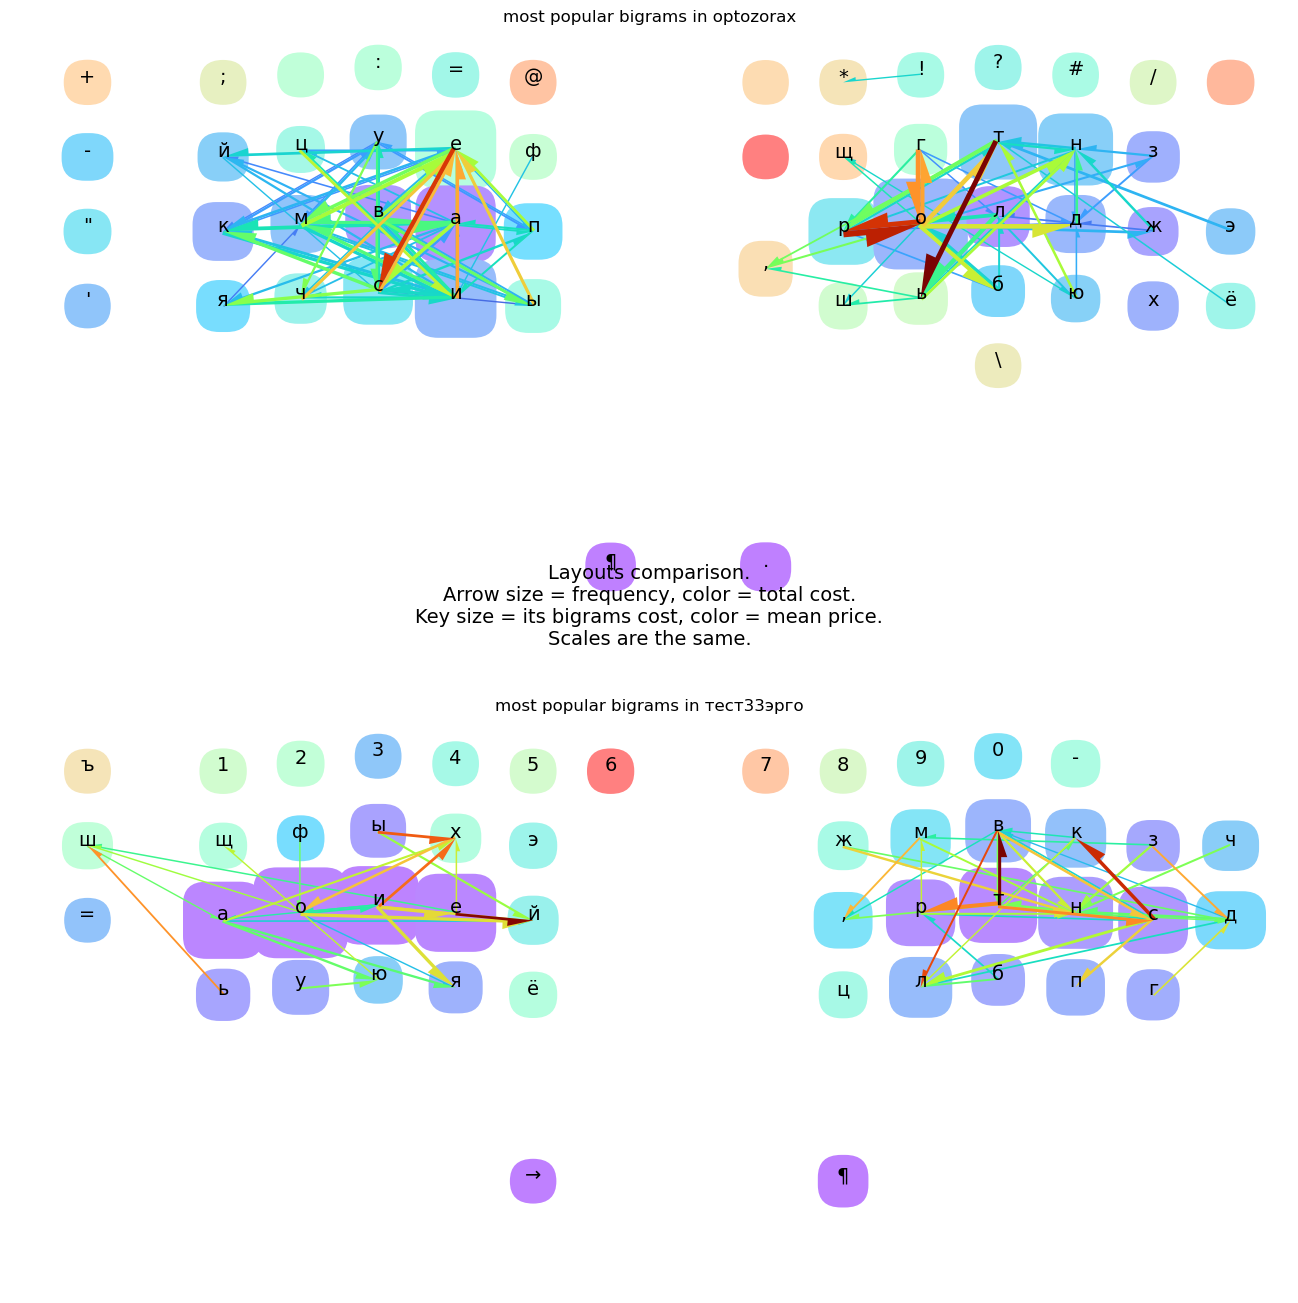

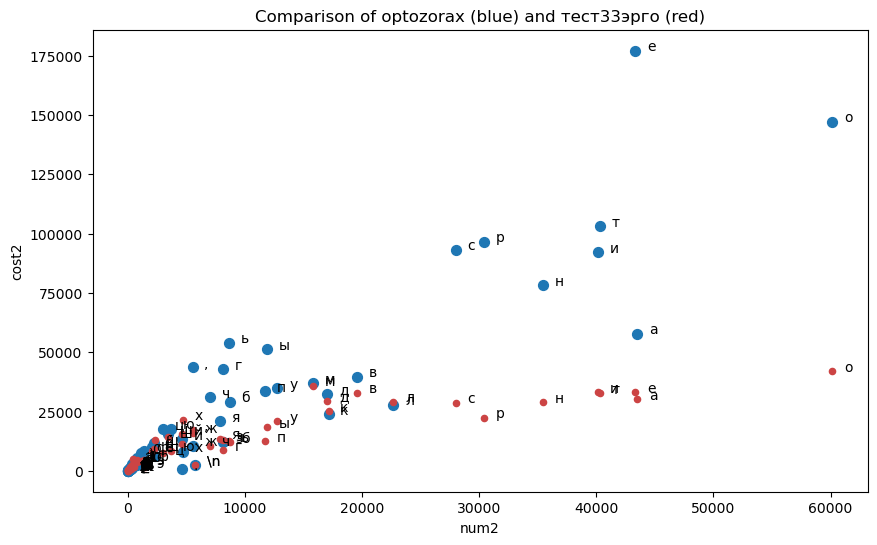

In [36]:
results['optozorax'].combomap(results['тест33эрго'])
results['optozorax'].combochart(results['тест33эрго'])

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

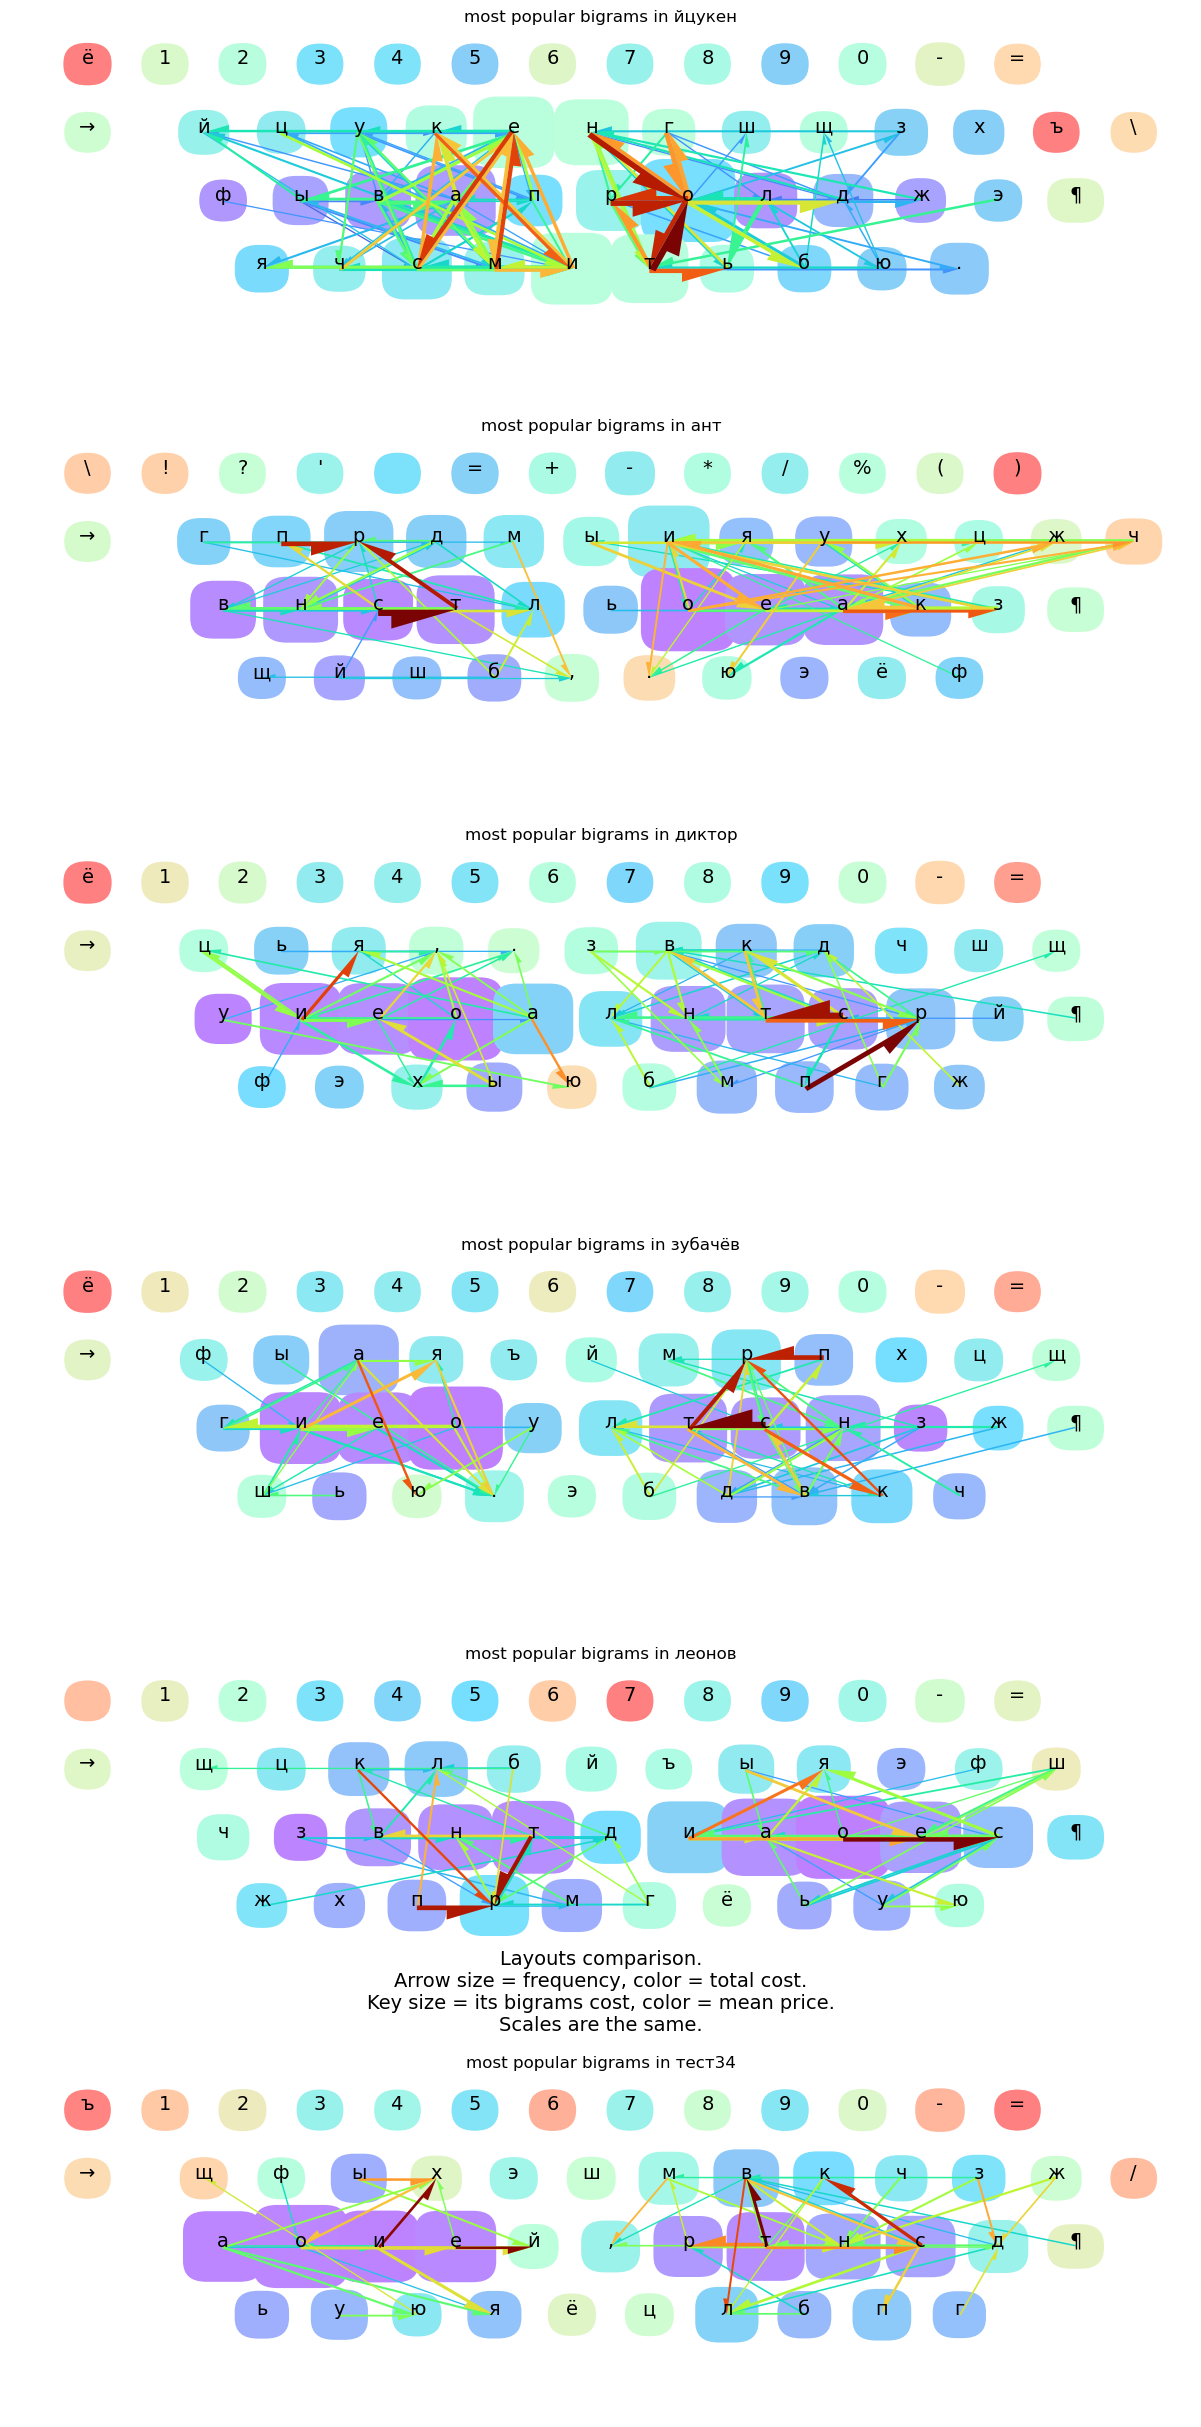

In [37]:
r = results
r['йцукен'].combomap(r['ант'], r['диктор'], r['зубачёв'], r['леонов'], r['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

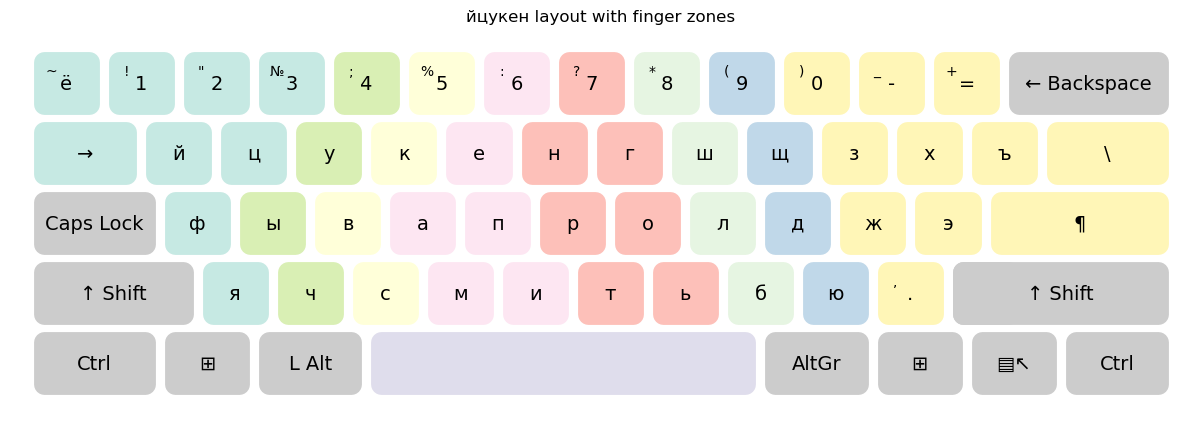

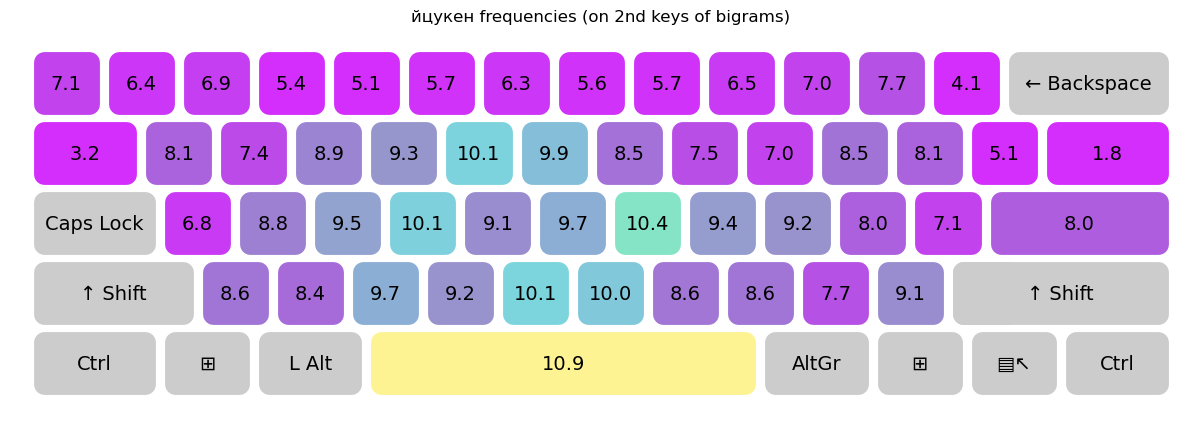

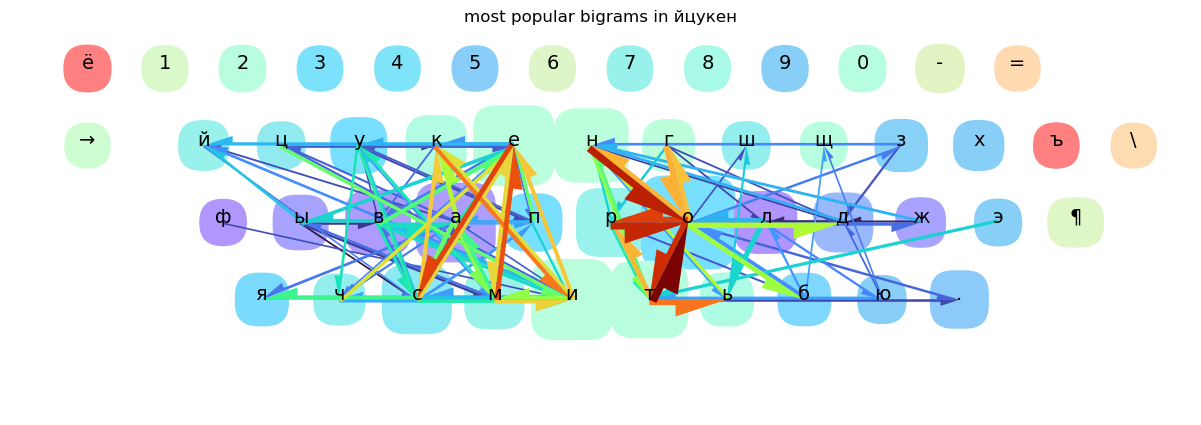

In [38]:
results['йцукен'].display('layout', 'num', 'arrows')

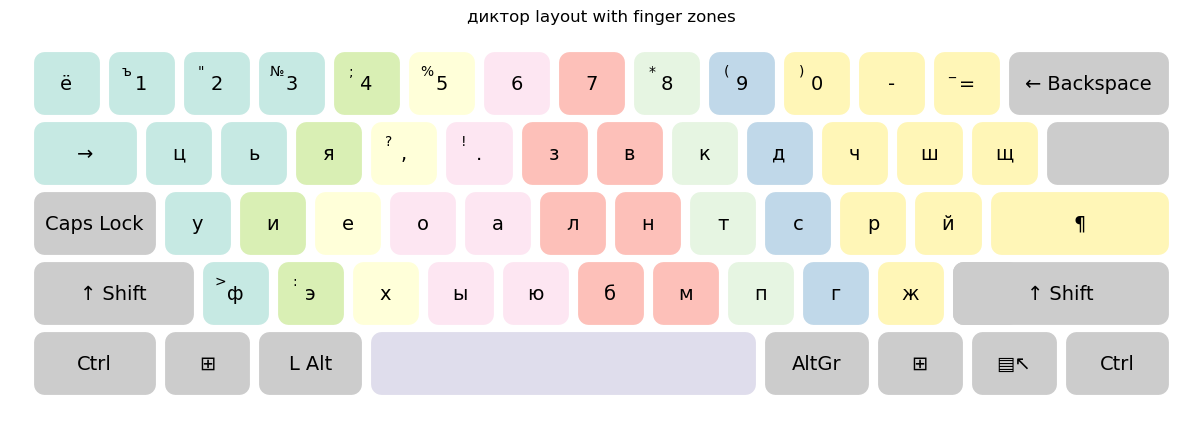

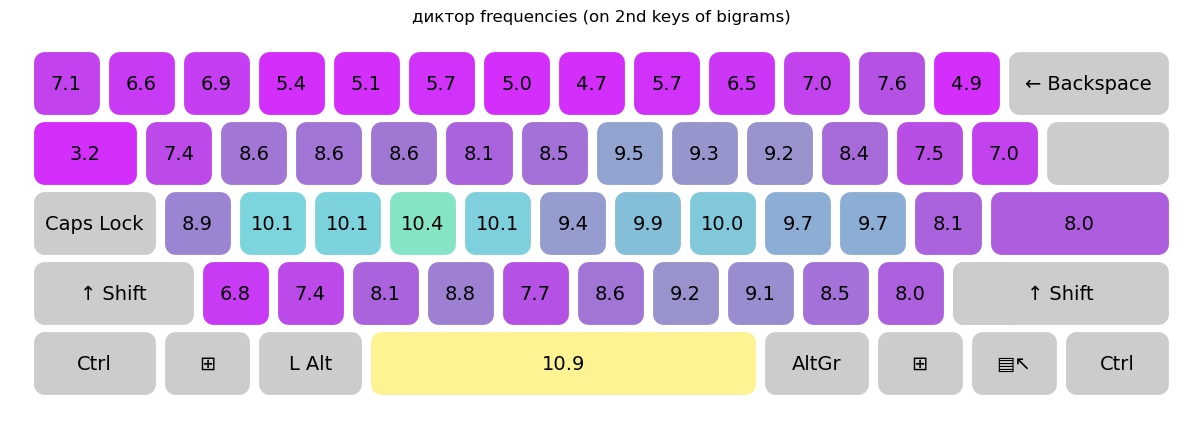

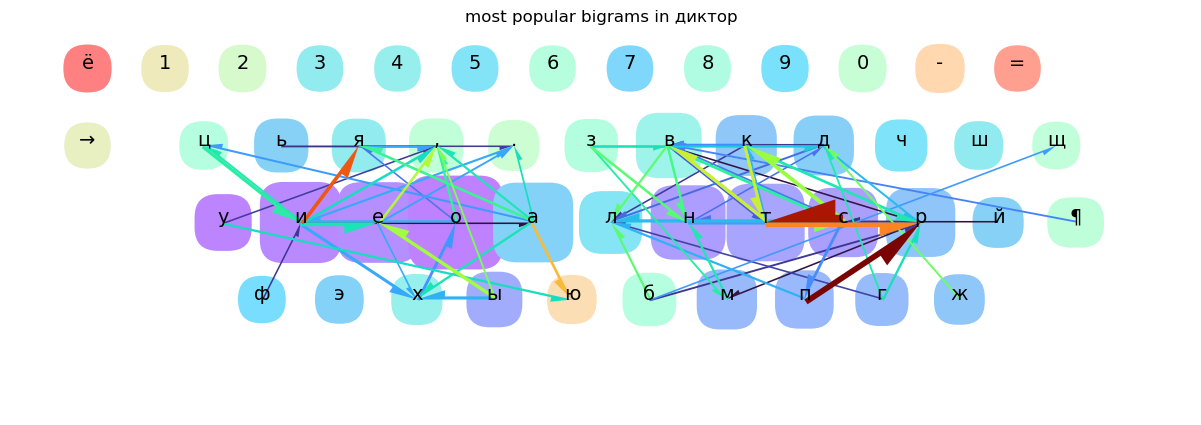

In [39]:
results['диктор'].display('layout', 'num', 'arrows')

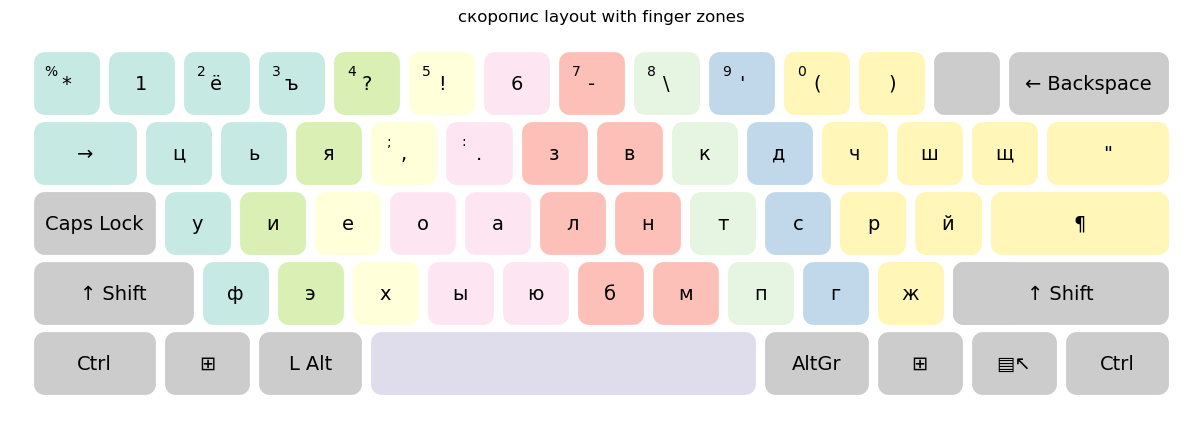

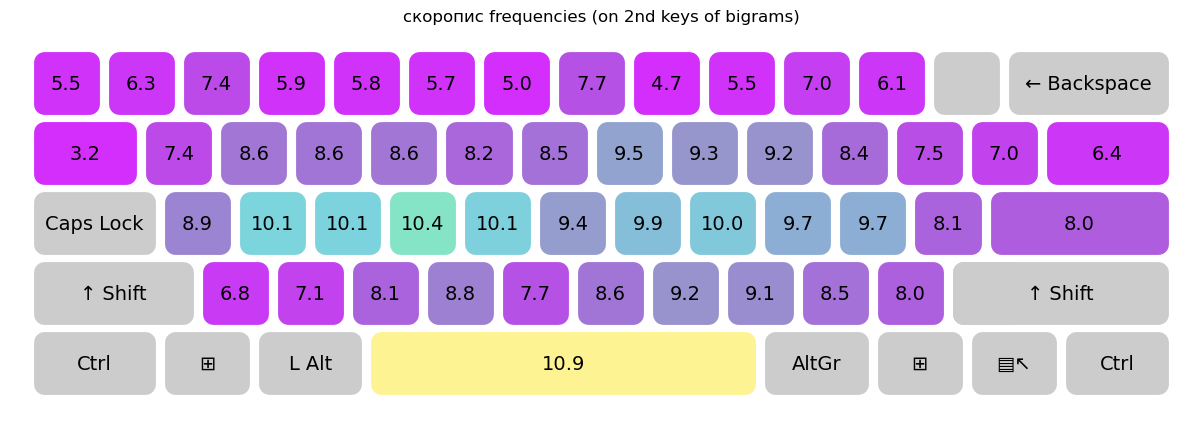

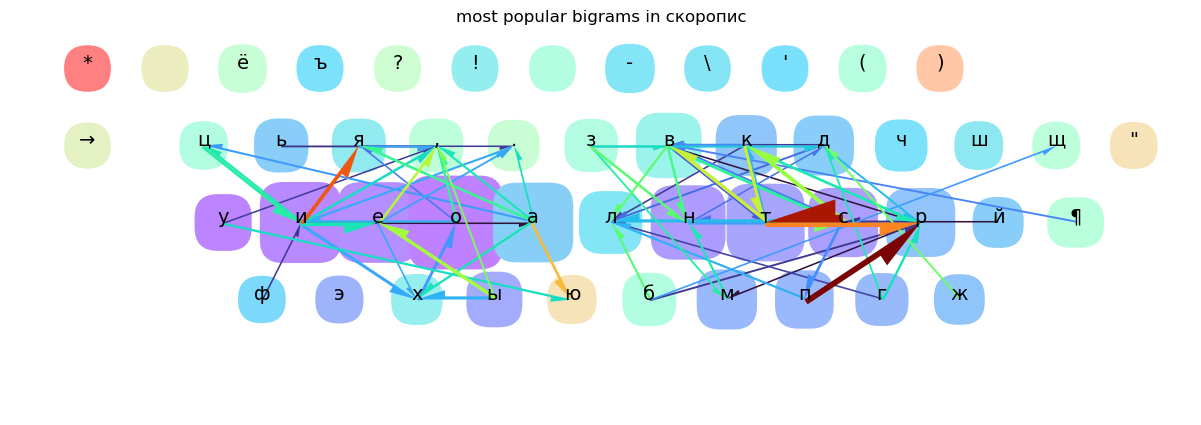

In [40]:
results['скоропис'].display('layout', 'num', 'arrows')

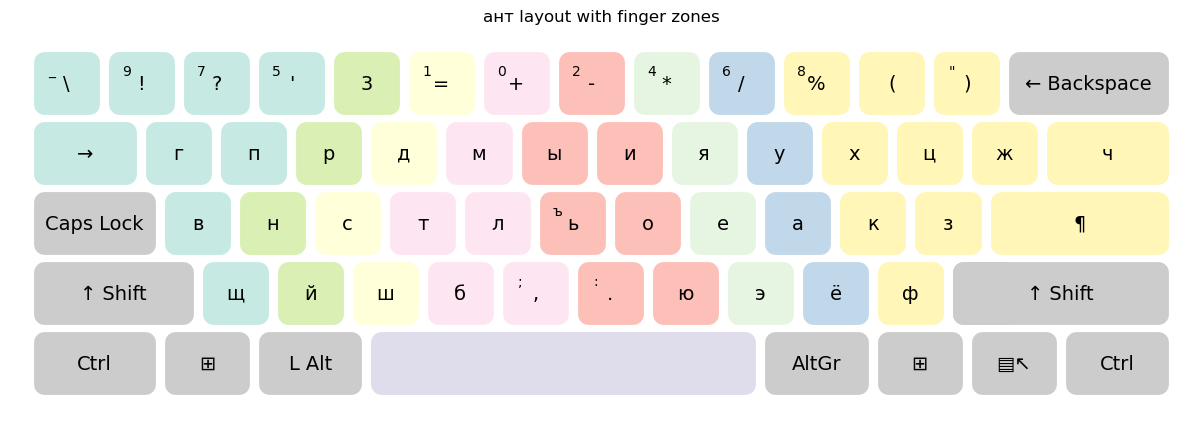

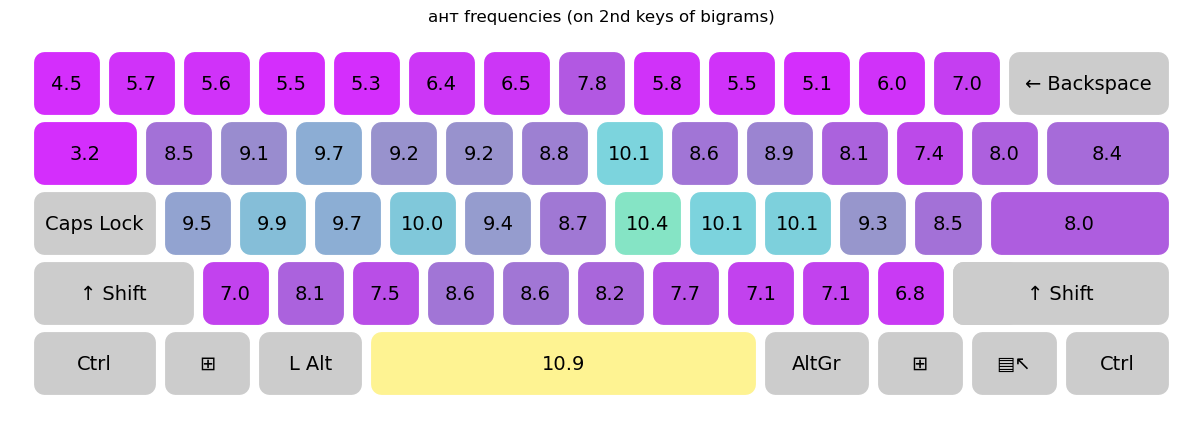

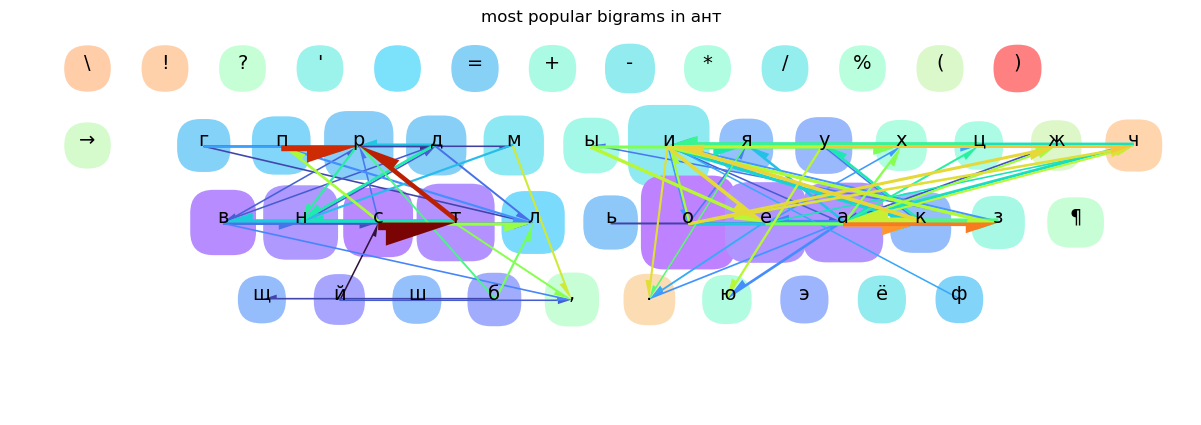

In [41]:
results['ант'].display('layout', 'num', 'arrows')

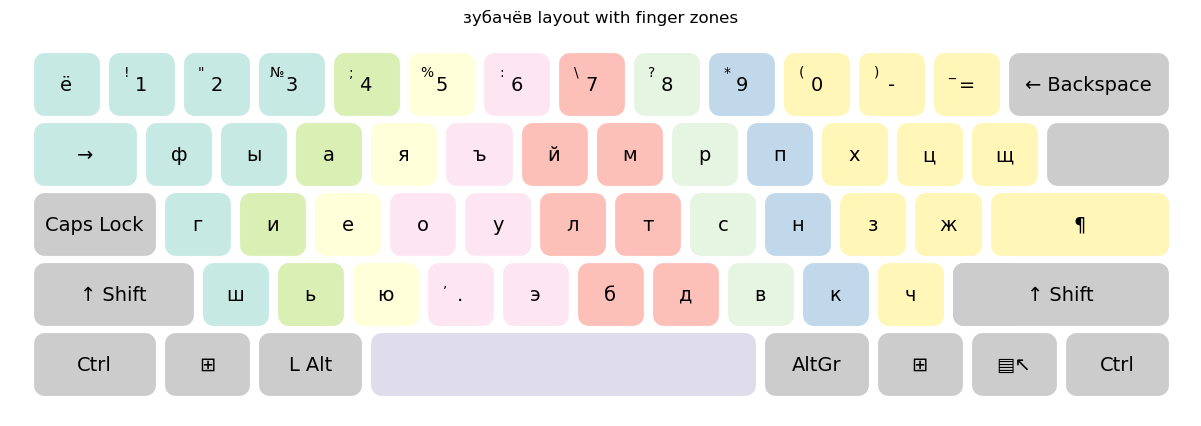

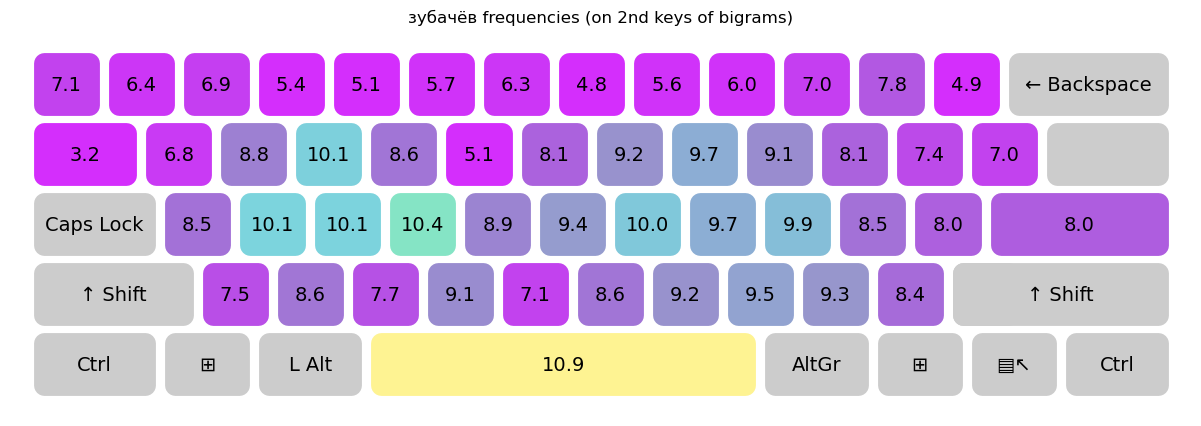

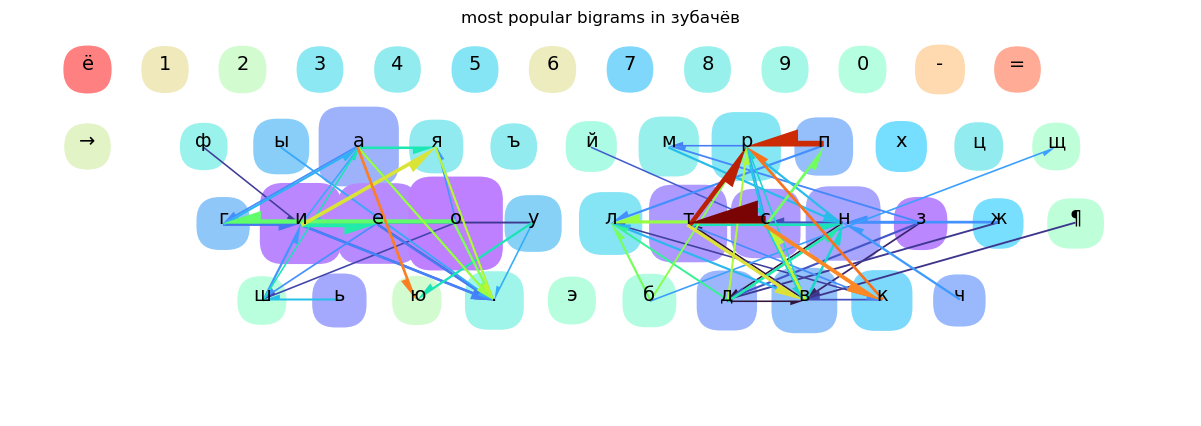

In [42]:
results['зубачёв'].display('layout', 'num', 'arrows')

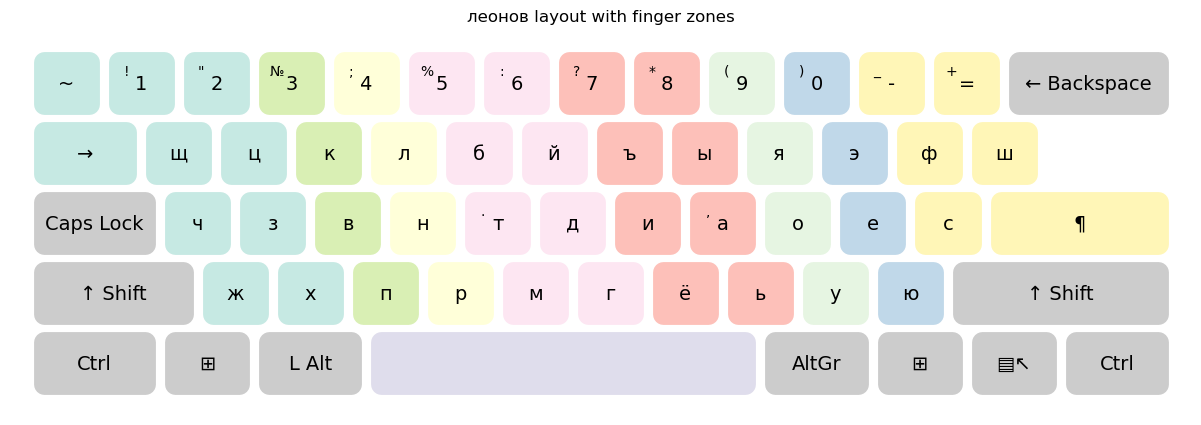

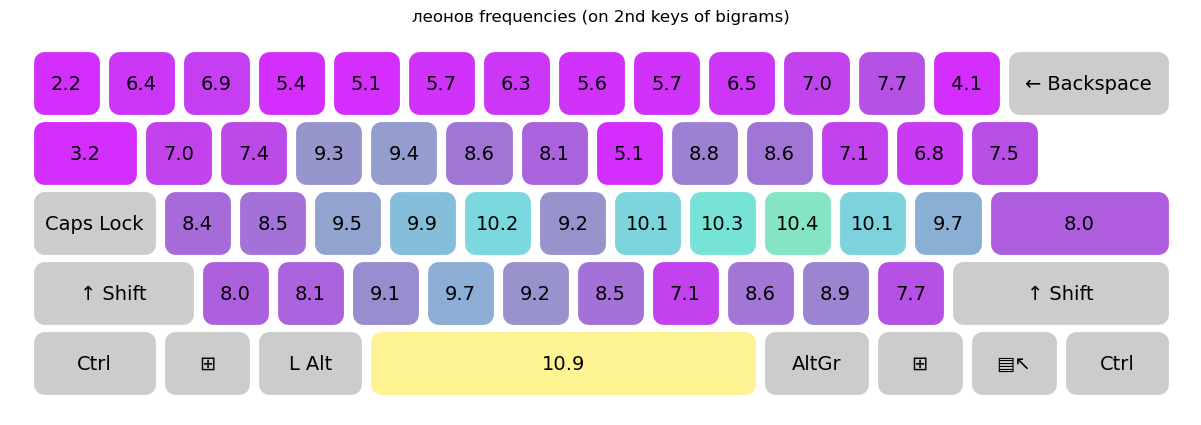

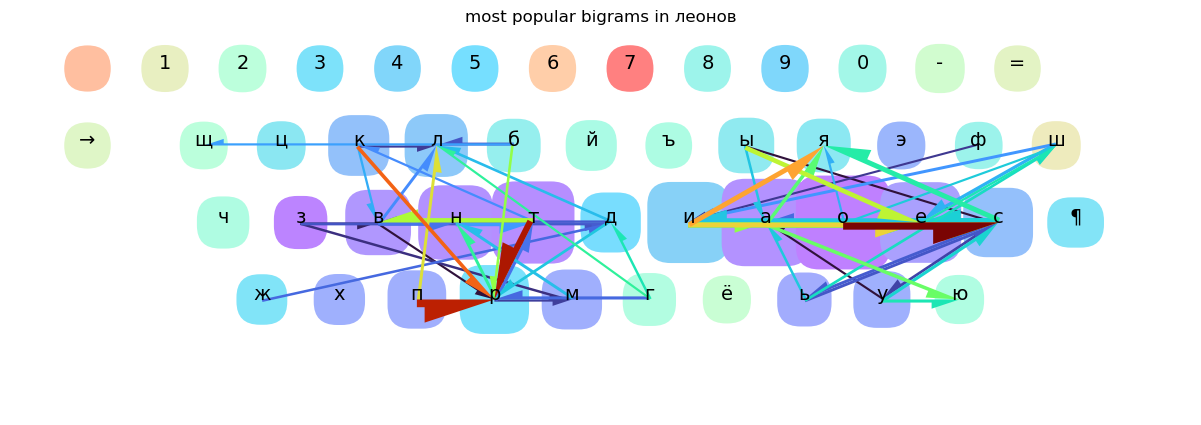

In [43]:
results['леонов'].display('layout', 'num', 'arrows')

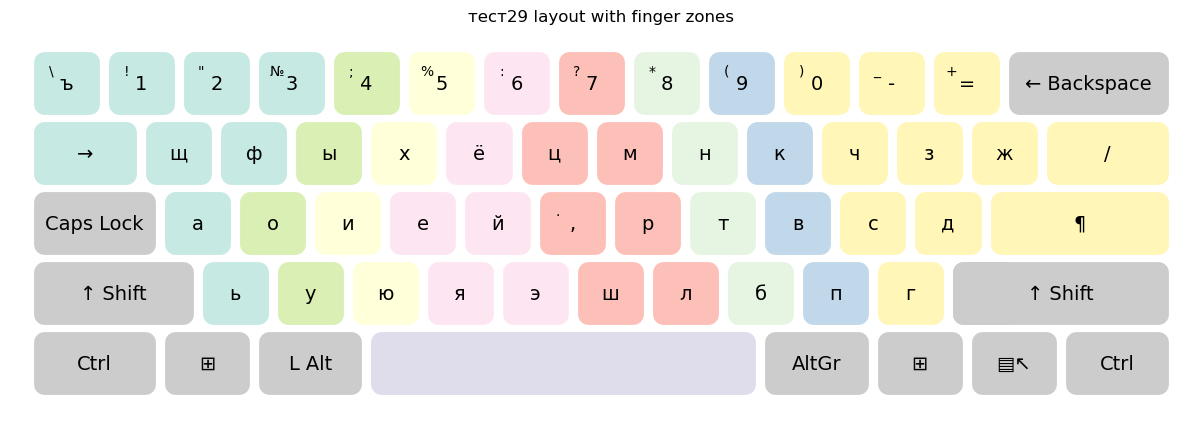

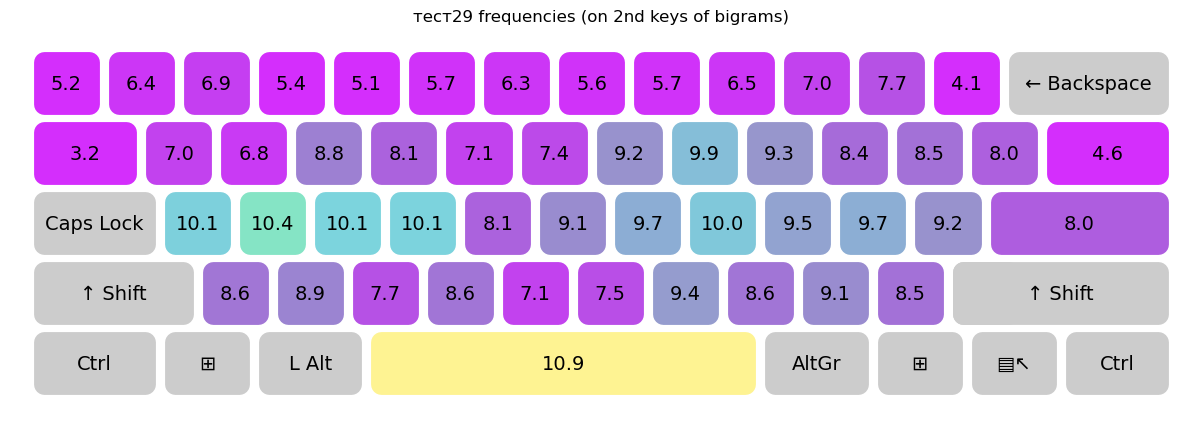

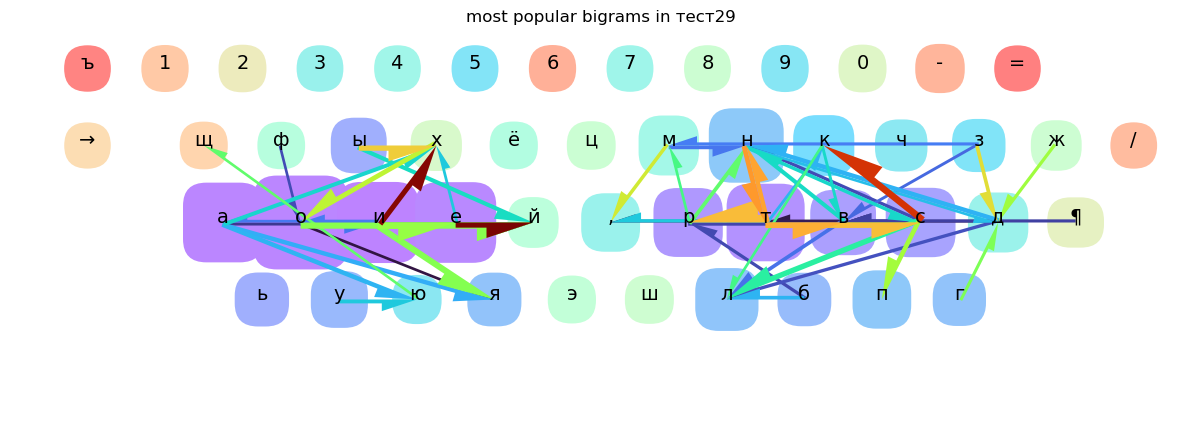

In [44]:
results['тест29'].display('layout', 'num', 'arrows')

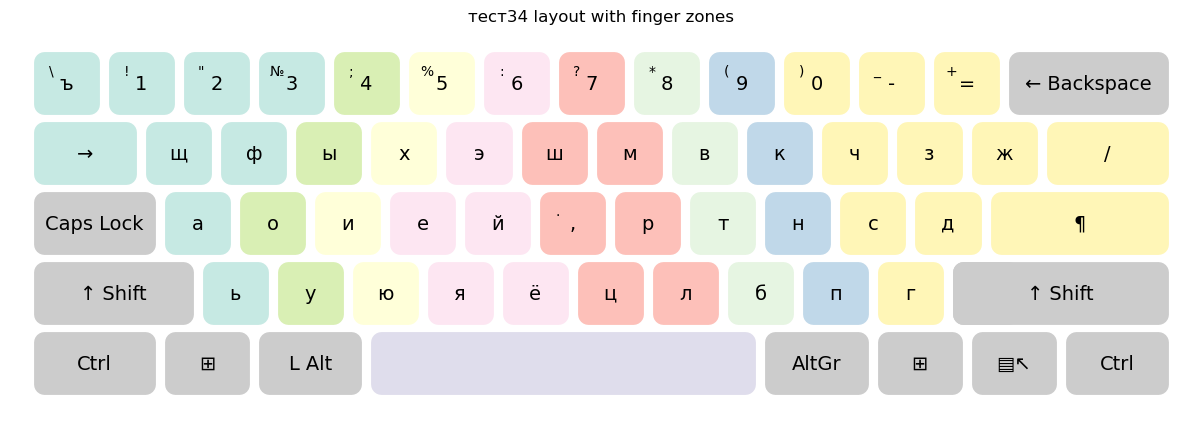

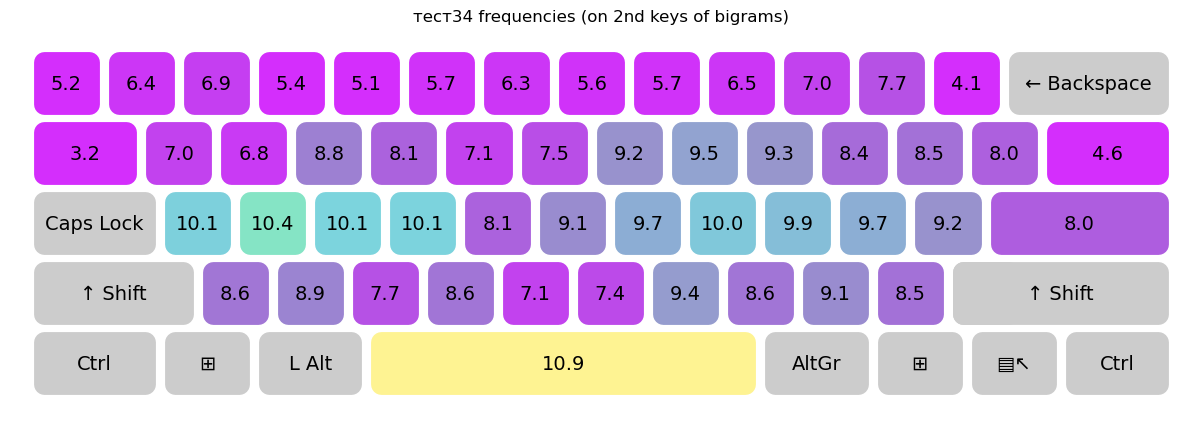

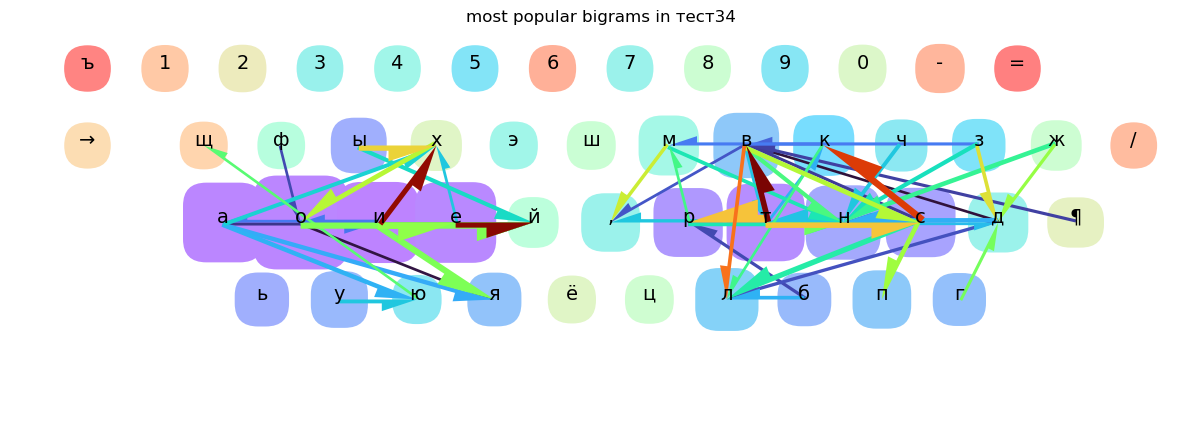

In [45]:
results['тест34'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [47]:
r = compare(results, 'леонов', 'тест32')
r.head(30)

bigram   num                     category_old  price_old  cost_old  \
55      по  3115                     altern hands          0         0   
18      ⌴в  4955                        space bar          0         0   
177     .¶  1085                     altern hands          2      2170   
194     хо   684                     altern hands          0         0   
114     ск  1284                     altern hands          1      1284   
130     тс   879                     altern hands          0         0   
262     ия  1139             out, over one finger          5      5695   
338     вл   403  in, adj finger, same or adj row          3      1209   
35      ов  3193                     altern hands          0         0   
296     ей   790                     altern hands          4      3160   
111     их   776                     altern hands          1       776   
182     ⌴э   983                        space bar          1       983   
303     па   477                     altern hands          0         0   
295     оп   568                     altern hands          1       568   
49      тв   926             out, over one finger          4      3704   
94      ⌴з  1384                        space bar          0         0   
465     вс   674                     altern hands          0         0   
38      ть  2493                     altern hands          1      2493   
447     зд   390      in, over 1 finger, same row          2       780   
116     аз  1101                     altern hands          0         0   
53      ¶¶  1033                         same key          2      2066   
46      ль  2056                     altern hands          1      2056   
498     зм   290       in, over 1 finger, adj row          2       580   
291     ап   336                     altern hands          1       336   
64      из   970                     altern hands          0         0   
387     жн   625       in, over 1 finger, adj row          1       625   
188     бщ   231                   index -> pinky          6      1386   
124     ⌴-   886                        space bar          4      3544   
71      ых   829                     altern hands          1       829   
14      тн   547           index->middle same row          1       547   

                        category_new  price_new  cost_new  delta  
55           pinky -> ring, next row          3      9345   9345  
18                         space bar          1      4955   4955  
177                   index -> pinky          6      6510   4340  
194              same finger adj row          6      4104   4104  
114          pinky -> ring, next row          4      5136   3852  
130             out, over one finger          4      3516   3516  
262              same finger adj row          8      9112   3417  
338              adj finger over row         11      4433   3224  
35                      altern hands          1      3193   3193  
296              same finger adj row          8      6320   3160  
111             out, over one finger          5      3880   3104  
182                        space bar          4      3932   2949  
303              same finger adj row          6      2862   2862  
295          ring -> pinky, next row          6      3408   2840  
49               same finger adj row          7      6482   2778  
94                         space bar          2      2768   2768  
465             out, over one finger          4      2696   2696  
38                      altern hands          2      4986   2493  
447              same finger adj row          8      3120   2340  
116                     altern hands          2      2202   2202  
53                          same key          4      4132   2066  
46                      altern hands          2      4112   2056  
498        over 1 finger, over 1 row          9      2610   2030  
291              same finger adj row          7      2352   2016  
64                      altern han

In [48]:
r.tail(30)

bigram   num                     category_old  price_old  cost_old  \
300     и,   557              same finger adj row          6      3342   
236     ны  2235                     altern hands          3      6705   
491     гл   227              adj finger over row         11      2497   
129     ае   572             out, over one finger          4      2288   
181     ой  1149                     altern hands          4      4596   
155     ие  1197             out, over one finger          4      4788   
110     ки  1228                     altern hands          2      2456   
147     ми  1241                     altern hands          2      2482   
156     ис  1273                   index -> pinky          2      2546   
69      ор  2584                     altern hands          1      2584   
184     ое   665             out, over one finger          4      2660   
238     ас  1409                   index -> pinky          2      2818   
133     ⌴ч  1466                        space bar          4      5864   
256     ые   996             out, over one finger          4      3984   
324     бр   308              adj finger over row         11      3388   
187     об  1698                     altern hands          3      5094   
225     ⌴б  1717                        space bar          3      5151   
28      ри  1724                     altern hands          2      3448   
33      ти  1934                     altern hands          2      3868   
252     пл   410              adj finger over row         11      4510   
79      ⌴г  1384                        space bar          4      5536   
153     ог  1500                     altern hands          4      6000   
7       ли  2626                     altern hands          2      5252   
78      тр  1768             out, over one finger          5      8840   
31      кр   615              adj finger over row         11      6765   
15      ни  3367                     altern hands          2      6734   
61      ес  1846             out, over one finger          4      7384   
23      ⌴и  4035                        space bar          2      8070   
41      пр  2820  in, adj finger, same or adj row          3      8460   
56      ос  2447             out, over one finger          4      9788   

                        category_new  price_new  cost_new  delta  
300                     altern hands          2      1114  -2228  
236                     altern hands          2      4470  -2235  
491      in, over 1 finger, same row          1       227  -2270  
129      in, over 1 finger, same row          0         0  -2288  
181      in, over 1 finger, same row          2      2298  -2298  
155  in, adj finger, same or adj row          2      2394  -2394  
110                     altern hands          0         0  -2456  
147                     altern hands          0         0  -2482  
156                     altern hands          0         0  -2546  
69                      altern hands          0         0  -2584  
184      in, over 1 finger, same row          0         0  -2660  
238                     altern hands          0         0  -2818  
133                        space bar          2      2932  -2932  
256       in, over 1 finger, adj row          1       996  -2988  
324       in, over 1 finger, adj row          1       308  -3080  
187                     altern hands          1      1698  -3396  
225                        space bar          1      1717  -3434  
28                      altern hands          0         0  -3448  
33                      altern hands          0         0  -3868  
252                     altern hands          1       410  -4100  
79                         space bar          1      1384  -4152  
153                     altern hands          1      1500  -4500  
7                       altern hands          0         0  -5252  
78   in, adj finger, same or adj row          2      3536  -5304  
31        in, over 1 finger, adj r

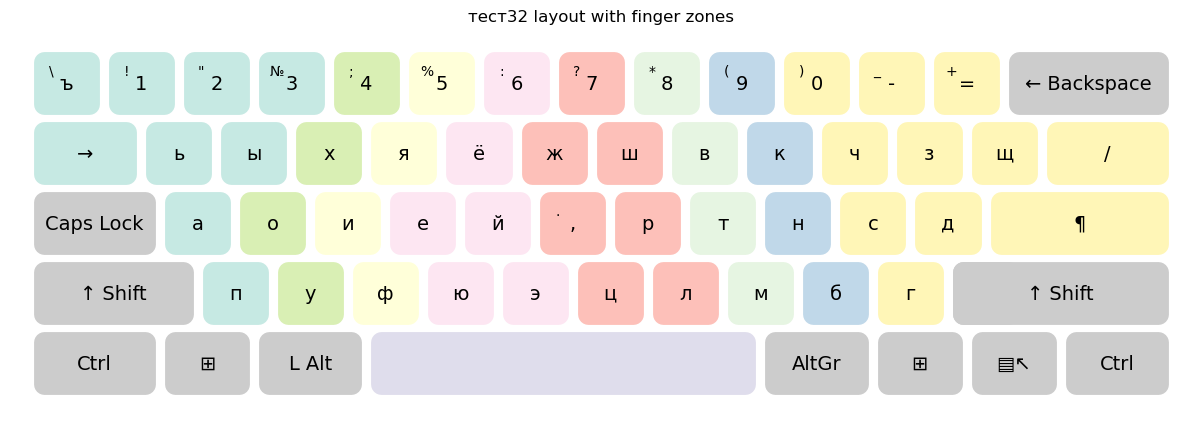

In [49]:
results['тест32'].layout.display()

# Same Method Applied to English

I took some New Yorker articles from archive.org. They're quite long. I replaced the pretty double/single quotes to standard, and long dash with standard hyphen, otherwise they're not counted at all.

In [50]:
ENG = Corpus.from_path('english.txt')

In [51]:
eng_layouts = {
    'sholes1': r'''
    
`12345 67890-=
→qwert yuiop[]\
 asdfg hjkl;'¶
 zxcvb nm,./
⌴

~!"#$% ^&*()_+
 ∅∅∅∅∅ ∅∅∅∅∅{}|
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
∅
''',

    'dvorak': r'''
`12345 67890[]
→',.py fgcrl/=\
 aoeui dhtns-¶
 ;qjkx bmwvz
⌴

~!"#$% ^&*(){}
 "<>∅∅ ∅∅∅∅∅?+|
 ∅∅∅∅∅ ∅∅∅∅∅_
 :∅∅∅∅ ∅∅∅∅∅
∅
''',
    'colemak': r'''
`12345 67890-=
→qwfpg jluy;[]\
 arstd hneio'¶
 zxcvb km,./
⌴

~!"#$% ^&*()_+
 ∅∅∅∅∅ ∅∅∅∅:{}|
 ∅∅∅∅∅ ∅∅∅∅∅"∅
 ∅∅∅∅∅ ∅∅<>?
∅
''',
  
    # note: 0 & 1 weren't there in the real layout.
    'sholes2': r'''
012345 6789$&z
→xpmch rtnsdgk`
 jbwfl aeiouy¶
 qv:;. ,!?-"_
⌴

~@#∅% ^∅*()_+
 ∅∅∅∅∅ ∅∅∅∅:{}|
 ∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅[]< >∅∅∅∅∅
∅
''',

}


In [52]:
LT = {'v': 'aeiou', 'c': 'bcdfghjklmnpqrstvwxyz'}

# these keys MUST be in any layout, otherwise the code throws an exception and halts
ENG_BASE = set('`-!?%*():;.,⌴¶abcdefghijklmnopqrstuvwxyz')

eng_res = {}
for k, l in eng_layouts.items():
    print(k, end=': ')
    eng_res[k] = r = Result(ENG, Layout(k, l, base_keys=ENG_BASE))
    print(r.score)

sholes1: key """ repeated: 2
2.5886838778388883
dvorak: key """ repeated: 2
1.178944972215786
colemak: key """ repeated: 2
1.259883009556794
sholes2: key ":" repeated: 2
key "_" repeated: 2
2.6773413332357734


Dvorak layout is still the best, if we weigh bigrams seriously. Colemak was a mix of both, and scores slightly worse, but not as badly as I expected.

## Arrow Maps

The less arrows, the better.

Look at the arrow maps: almost all arrows are thin, and there are few of them. QWERTY has lots of thick arrows. Colemak has noteably more than Dvorak, but the score is quite ok.

I expected Colemak to have a lot of costs on the left hand, but it has more on the right.

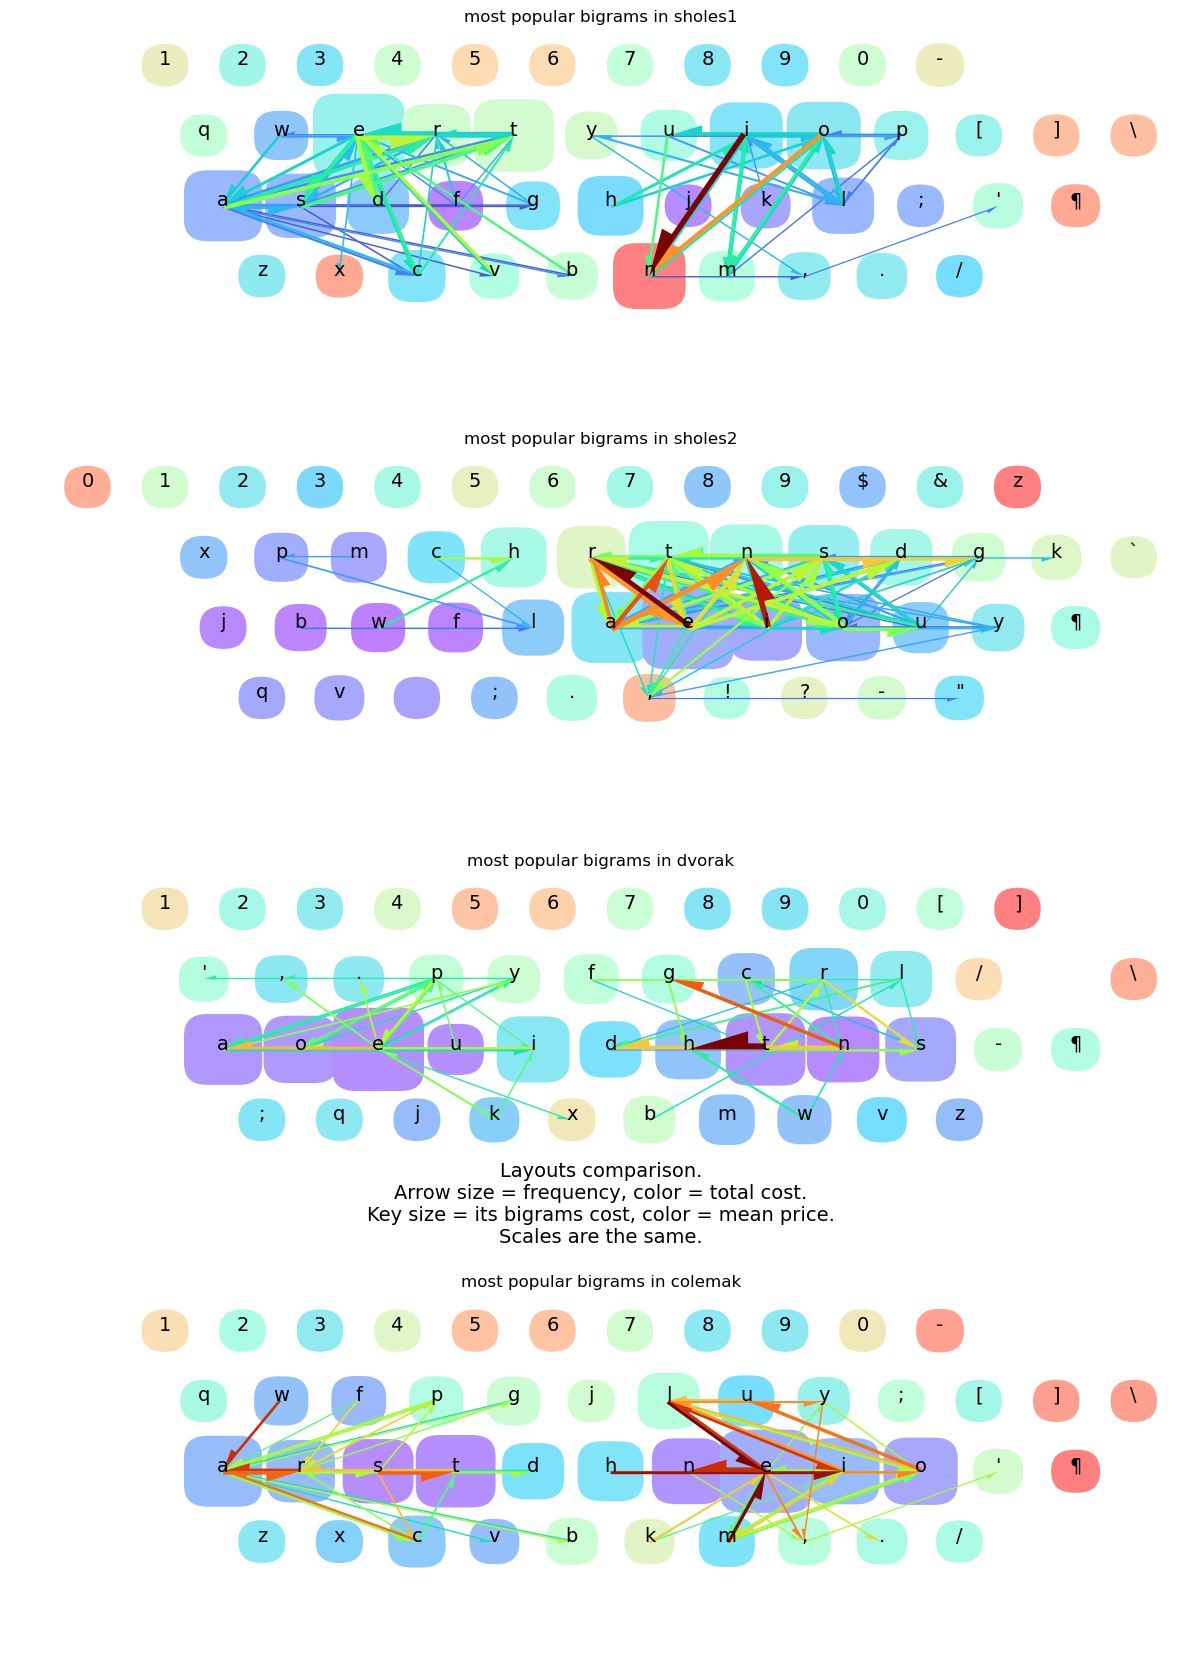

In [53]:
eng_res['sholes1'].combomap(eng_res['sholes2'], eng_res['dvorak'], eng_res['colemak'])